## ⚙️ Import Libraries

In [1]:
# Set seed for reproducibility
seed = 42

import os
from datetime import datetime
import copy

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import optuna
import logging
import time
import numpy as np
import random
import albumentations as A
import pandas as pd
from collections import Counter


# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)


import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import backend as K
from keras.saving import register_keras_serializable


# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


# Data cleaning

While plotting the images and their corresponding segmentations from the original training set, mars_for_students.npz, we identified some outliers (images containing an alien). We also observed that the outlier images (samples in X_train) differ from each other, whereas their corresponding segmentations are identical.  
To avoid processing the outliers in the future, we created a new dataset, cleaned_dataset.npz, which excludes these outliers.

In [ ]:
"""
data = np.load("mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")
"""

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


In [ ]:
"""
# function that returns the list of the outliars' indices in y_train
# idx is the index corresponding to an outliar (found by visualization)

def find_outliers_idx(y_train, idx):
    # Extract the reference outlier
    outlier_reference = y_train[idx]

    # Initialize a list to store the indices of the outliers
    outliers_indices = []

    for i in range(y_train.shape[0]):
        if np.array_equal(y_train[i], outlier_reference):
            # If they are the same, add index i to the list of outlier indices
            outliers_indices.append(i)

    return outliers_indices


outlier_indices = find_outliers_idx(y_train, 62)
print(f"Number of outliers: {len(outlier_indices)}")
print("Indices of outliers:", outlier_indices)
"""

Number of outliers: 110
Indices of outliers: [62, 79, 125, 139, 142, 147, 152, 156, 170, 210, 217, 266, 289, 299, 313, 339, 348, 365, 412, 417, 426, 450, 461, 536, 552, 669, 675, 741, 744, 747, 799, 802, 808, 820, 821, 849, 863, 890, 909, 942, 971, 1005, 1057, 1079, 1082, 1092, 1095, 1106, 1119, 1125, 1177, 1194, 1224, 1247, 1248, 1258, 1261, 1262, 1306, 1324, 1365, 1370, 1443, 1449, 1508, 1509, 1519, 1551, 1584, 1588, 1628, 1637, 1693, 1736, 1767, 1768, 1782, 1813, 1816, 1834, 1889, 1925, 1942, 1975, 1979, 2000, 2002, 2086, 2096, 2110, 2111, 2151, 2161, 2222, 2235, 2239, 2242, 2301, 2307, 2350, 2361, 2365, 2372, 2414, 2453, 2522, 2535, 2561, 2609, 2614]


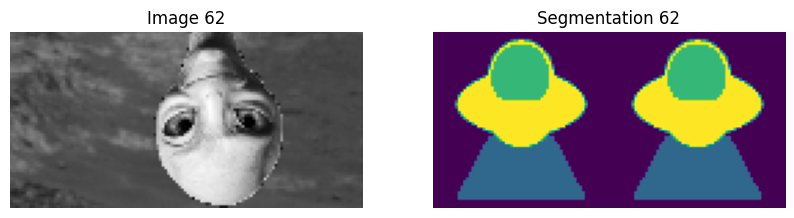

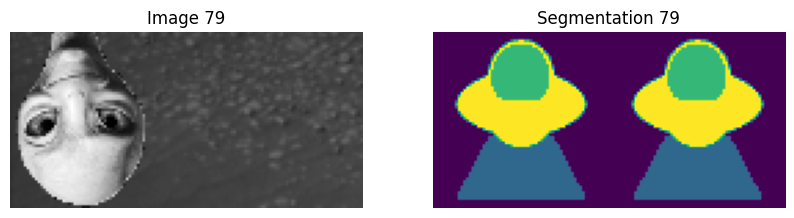

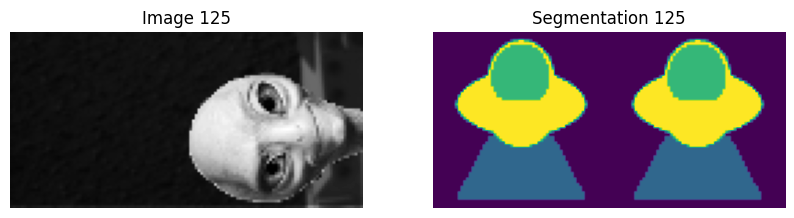

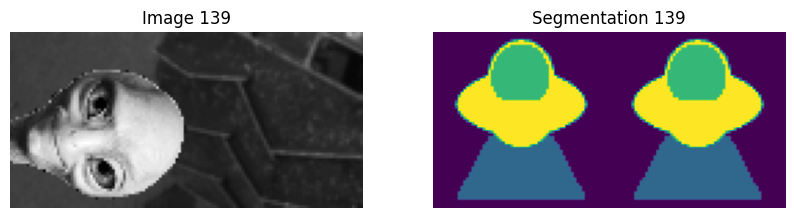

In [ ]:
"""
# Plot the first four outliars

for i in outlier_indices[:4]:
  _, axs = plt.subplots(1, 2, figsize=(10, 5))
  axs[0].imshow(X_train[i], cmap='gray')
  axs[0].set_title(f'Image {i}')
  axs[0].axis('off')
  axs[1].imshow(y_train[i])
  axs[1].set_title(f'Segmentation {i}')
  plt.axis('off')
  plt.show()
"""

In [ ]:
"""
# Remove outliers
X_train_cleaned = np.delete(X_train, outlier_indices, axis=0)
y_train_cleaned = np.delete(y_train, outlier_indices, axis=0)

print(f"X_train_cleaned shape: {X_train_cleaned.shape}")
print(f"y_train_cleaned shape: {y_train_cleaned.shape}")

# Save cleaned dataset
np.savez("data/cleaned_dataset.npz", training_set=np.stack((X_train_cleaned, y_train_cleaned), axis=1), test_set=X_test)
print("Saved cleaned dataset to 'cleaned_dataset.npz'.")
"""

X_train_cleaned shape: (2505, 64, 128)
y_train_cleaned shape: (2505, 64, 128)
Saved cleaned dataset to 'cleaned_dataset.npz'.


# ⏳ Load and Process Data

In [ ]:
data = np.load('/kaggle/input/cleaned-mars-dataset/cleaned_dataset.npz')

training_set = data["training_set"]
X_train_val = training_set[:, 0]
y_train_val = training_set[:, 1]

X_test = data["test_set"]

# Add color channel and rescale pixels between 0 and 1
X_train_val = X_train_val[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

print(f"X_train_val shape: {X_train_val.shape}")
print(f"y_train_val shape: {y_train_val.shape}")
print(f"X_test shape: {X_test.shape}")

X_train_val shape: (2505, 64, 128, 1)
y_train_val shape: (2505, 64, 128)
X_test shape: (10022, 64, 128, 1)


In [ ]:
NUM_CLASSES = len(np.unique(y_train_val))
input_shape = X_train_val.shape[1:]

# Define a mapping of labels to their corresponding digit names
labels = {0: "Background", 1: "Soil", 2: "Bedrock", 3: "Sand", 4: "Big Rock"}
labels_name = list(labels.values())

print(f"Input shape: {input_shape}")
print(f"Number of classes: {NUM_CLASSES}")
print('\nClasses: ', labels)

Input shape: (64, 128, 1)
Number of classes: 5

Classes:  {0: 'Background', 1: 'Soil', 2: 'Bedrock', 3: 'Sand', 4: 'Big Rock'}


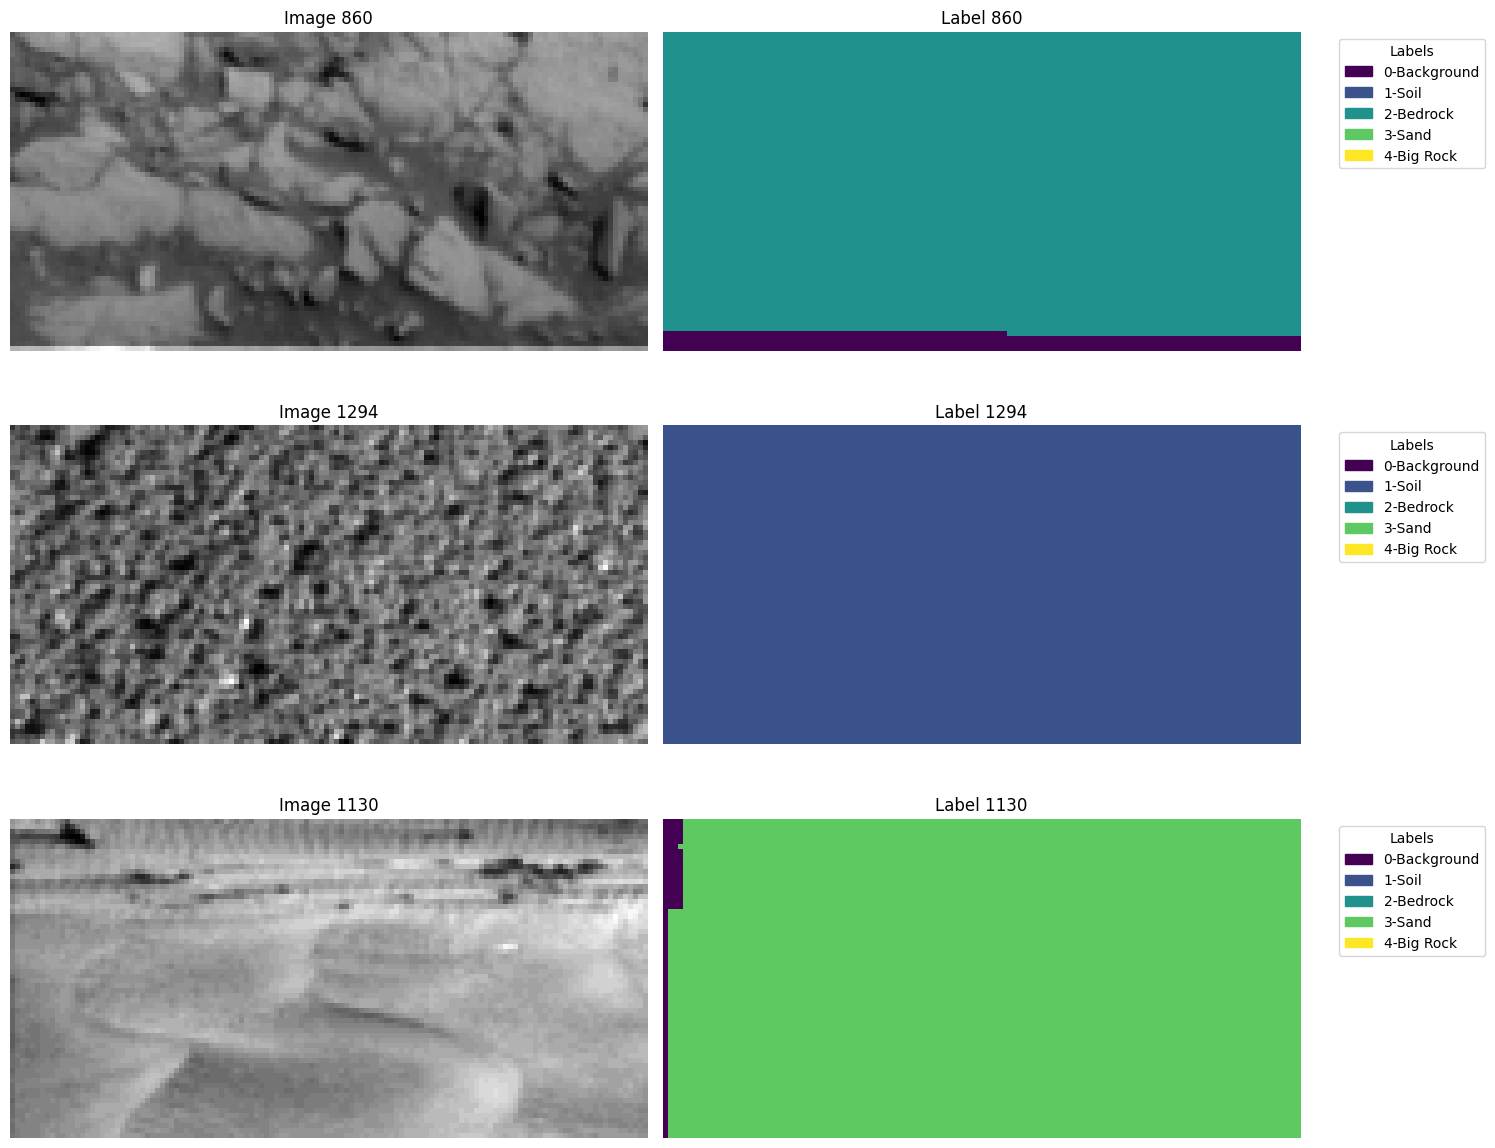

In [ ]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))



def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]
    return colored



def add_colormap_legend(colormap, num_classes, labels_name):
    """
    Add a legend to the plot to show the mapping between labels and colors.

    Parameters:
    - colormap: The colormap used for segmentation.
    - num_classes: Number of classes.
    """
    patches = []
    for i in range(num_classes):
        color = colormap[i][:3]  # RGB values
        label = f"{i}-{labels_name[i]}"  # Customize label as needed
        patches.append(mpatches.Patch(color=color, label=label))

    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', title="Labels")



def plot_sample_batch(X, y, labels_name, num_samples=3):
    """
    Display some image and label pairs from X and y with a legend.

    Parameters:
    - X: NumPy array of images, shape (N, H, W) or (N, H, W, C)
    - y: NumPy array of labels, shape (N, H, W)
    - num_samples: Number of samples to display
    """
    plt.figure(figsize=(15, 4 * num_samples))

    # Determine the number of classes from the labels
    num_classes = len(labels_name)
    colormap = create_segmentation_colormap(num_classes)

    # take random indices
    idx_rand = np.random.randint(0, X.shape[0], num_samples)

    for i, idx in enumerate(idx_rand):
        # Plot the original image
        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.imshow(X[idx], cmap='gray')
        plt.title(f'Image {idx}')
        plt.axis('off')

        # Plot the colored label
        plt.subplot(num_samples, 2, i * 2 + 2)
        colored_label = apply_colormap(y[idx], colormap)
        plt.imshow(colored_label)
        plt.title(f'Label {idx}')
        plt.axis('off')
        add_colormap_legend(colormap, num_classes, labels_name)

    plt.tight_layout()
    plt.show()
    plt.close()



# visualize some samples
plot_sample_batch(X_train_val, y_train_val, labels_name, num_samples=3)

[4988826 6957538 4776810 3770823   26963]


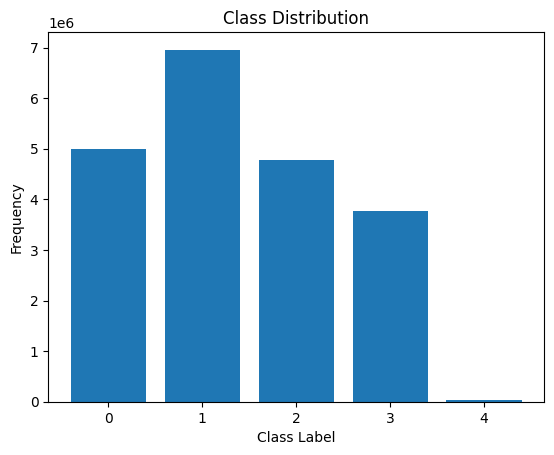

In [ ]:
mask_list = copy.deepcopy(y_train_val).astype(int)  # Each mask is a NumPy array

# Flatten all masks into a single array
all_pixels = np.concatenate([mask.flatten() for mask in mask_list])

# Count the frequency of each class
class_counts = np.bincount(all_pixels)
print(class_counts)

unique_classes = np.unique(all_pixels)
# Plot the class distribution
plt.bar(unique_classes, class_counts)
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

In [ ]:
def calculate_class_weights(mask_dataset):
    class_counts = Counter()
    total_pixels = 0
    for mask in mask_dataset:
        mask_flat = mask.flatten()
        class_counts.update(mask_flat)
        total_pixels += len(mask_flat)

    class_weights = {
        class_id: total_pixels / (len(class_counts) * count)
        for class_id, count in class_counts.items()
    }

    return class_weights

class_weights = calculate_class_weights(mask_list)
print("Class weights: ", class_weights)

Class weights:  {2: 0.8591909663562084, 0: 0.8226769183771894, 3: 1.088407490884616, 1: 0.5898914242365618, 4: 152.21570300040796}


### Splitting the data...

In [ ]:
# shuffle the data
X_train_val, y_train_val = shuffle(X_train_val, y_train_val, random_state=seed)

# Split train_val data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=seed)

print(f"Number of images:")
print(f"Train: {len(X_train)}")
print(f"Validation: {len(X_val)}")
print(f"Test: {len(X_test)}")

Number of images:
Train: 2129
Validation: 376
Test: 10022


### Data Augmentation

In [ ]:
# function to visualize and better understand the augmentation transformations
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18

    _, ax = plt.subplots(2, 2, figsize=(8, 8))

    ax[0, 0].imshow(original_image, cmap='gray')
    ax[0, 0].set_title('Original image', fontsize=fontsize)
    ax[0, 0].axis('off')

    ax[1, 0].imshow(original_mask)
    ax[1, 0].set_title('Original mask', fontsize=fontsize)
    ax[1, 0].axis('off')

    ax[0, 1].imshow(image, cmap='gray')
    ax[0, 1].set_title('Transformed image', fontsize=fontsize)
    ax[0, 1].axis('off')

    ax[1, 1].imshow(mask)
    ax[1, 1].set_title('Transformed mask', fontsize=fontsize)
    ax[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Define augmentations

augment = A.Compose([
    # Geometric transformations
    A.OneOf([
        A.RandomCrop(width=50, height=50, p=0.3), # cropping
        A.Affine(rotate=(-30, 30), translate_percent=(0.1, 0.2), p=0.3), # rotation and translation
        A.HorizontalFlip(p=0.2), # horizontal flipping
        A.VerticalFlip(p=0.2) # vertical flipping
    ]),
    # Color-based augmentations
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
    ]),
    # Elastic distorsions (moderate intensity)
    A.ElasticTransform(alpha=30, sigma=5, alpha_affine=5, p=0.2),
    # Resize to target dimensions
    A.Resize(width=128, height=64, always_apply=True)
])

In [ ]:
# Get indices of samples containing pixels of class 4 (rare)

def get_class4_indices(masks):
    return np.array([np.any(mask == 4) for mask in masks])

In [ ]:
# Generator function for yielding batches of augmented data with multiple augmentations per image

def data_generator(images, masks, batch_size=32, num_augmentations=3, oversample_factor=5):

    # Oversample class 4
    class4_indices = get_class4_indices(masks)
    non_class4_indices = ~class4_indices

    while True:  # Infinite loop to generate data for every epoch
        # Shuffle the data at the start of every epoch
        indices = np.arange(len(images))
        np.random.shuffle(indices)

        batch_images = []
        batch_masks = []

        for i in range(0, len(images), batch_size):
            # Get the indices for the current batch
            batch_indices = indices[i:i + batch_size]

           # Clear the lists for the batch data
            batch_images = []
            batch_masks = []

            # Collect images and masks for the current batch
            for idx in batch_indices:
                image = images[idx]
                mask = masks[idx]

                # Dynamic oversampling for class 4 images
                current_num_augs = num_augmentations
                if class4_indices[idx]:
                    current_num_augs *= oversample_factor # increase augmentation factor

                # Apply augmentations multiple times
                for _ in range(current_num_augs):
                    augmented = augment(image=image, mask=mask)
                    batch_images.append(augmented['image'])
                    batch_masks.append(augmented['mask'])

            # Convert the batch to numpy arrays
            batch_images = np.array(batch_images)
            batch_masks = np.array(batch_masks)

            # Yield the batch for training
            yield batch_images, batch_masks

# 🛠️ Models and Experiments

In [ ]:
def residual_block(inputs, filters, activation='relu', name='residual_block', kernel_regularizer=None):

    """

    residual block used in the bridge layer of the unet

    """

    with tf.name_scope(name):

        # Path 1: Convolutional bottleneck

        x1 = tfkl.Conv2D(filters // 4, kernel_size=1, padding='same',

                    kernel_regularizer=kernel_regularizer)(inputs)

        x1 = tfkl.BatchNormalization()(x1)

        x1 = tfkl.Activation(activation)(x1)



        # Central dilated convolution

        x1 = tfkl.Conv2D(filters // 4, kernel_size=3, dilation_rate=2, padding='same',

                    kernel_regularizer=kernel_regularizer)(x1)

        x1 = tfkl.BatchNormalization()(x1)

        x1 = tfkl.Activation(activation)(x1)



        x1 = tfkl.Conv2D(filters, kernel_size=1, padding='same',

                         kernel_regularizer=kernel_regularizer)(x1)

        x1 = tfkl.BatchNormalization()(x1)



        # Path 2: Identity shortcut (residual connection)

        x2 = tfkl.Conv2D(filters, kernel_size=1, padding='same',

                         kernel_regularizer=kernel_regularizer)(inputs)

        x2 = tfkl.BatchNormalization()(x2)



        # Squeeze-and-Excitation block for attention

        se = tfkl.GlobalAveragePooling2D(keepdims=True)(x1)

        se = tfkl.Dense(filters // 16, activation='relu')(se)

        se = tfkl.Dense(filters, activation='sigmoid')(se)

        x1 = tfkl.Multiply()([x1, se]) # apply attention



        # Channel Gating for adaptive weighting

        gate = tfkl.Dense(1, activation='sigmoid')(se) # Gating scalar

        x1 = tfkl.Multiply()([x1, gate])



        # Combine paths (residual addition)

        output = tfkl.Add()([x1, x2])

        output = tfkl.Activation('relu')(output)



        return output

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, kernel_regularizer=None, activation='relu', stack=2, name='',

               use_residual=True, use_se_block=True, dilation_rate=1, normalization='batch'):

    # Initialise the input tensor

    x = input_tensor



    for i in range(stack):

        # Convolution layer with dilation

        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', dilation_rate=dilation_rate,

                        kernel_regularizer=kernel_regularizer, name=name + 'conv' + str(i + 1))(x)



        # Normalization

        if normalization == 'batch':

            x = tfkl.BatchNormalization(name=name+'bn'+str(i + 1))(x)

        elif normalization == 'layer':

            x = tfkl.LayerNormalization(name=name+'ln'+str(i + 1))(x)

        if normalization == 'group':

            x = tfkl.experimental.SyncBatchNormalization(name=name+'gn'+str(i + 1))(x)



        # Activation

        x = tfkl.Activation(activation, name=name+'activation'+str(i + 1))(x)



    # Add residual connection

    if use_residual:

        residual = tfkl.Conv2D(filters, kernel_size=1, padding='same', name=name+'residual')(input_tensor)

        x = tfkl.Add(name=name+'add')([x, residual])



    # Add Squeeze-and-Excitation block

    if use_se_block:

        se = tfkl.GlobalAveragePooling2D(keepdims=True, name=name+'se_gap')(x)

        se = tfkl.Dense(filters // 16, activation='relu', name=name+'se_fc1')(se)

        se = tfkl.Dense(filters, activation='sigmoid', name=name+'se_fc2')(se)

        x = tfkl.Multiply(name=name+'se_multiply')([x, se])



    return x

In [ ]:
def AttentionGate(gate_channels):

    def _attention_gate(inputs):

        x1, x2 = inputs



        # Concatenate the input features along the channel dimension

        # Use tfkl.Concatenate instead of tf.concat

        concat_features = tfkl.Concatenate(axis=-1)([x1, x2])



        # Apply convolutional layers to extract attention features

        attention_features = tfkl.Conv2D(gate_channels, kernel_size=3, padding='same', activation='relu')(concat_features)

        attention_map = tfkl.Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')(attention_features)



        # Apply attention to x2

        x2_attention = tfkl.Multiply()([x2, attention_map])



        # Combine the features

        output = tfkl.Add()([x1, x2_attention])

        return output



    return _attention_gate

In [ ]:
def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, name=None, skip_method=tfkl.Concatenate, seed=seed):

    tf.random.set_seed(seed)

    input_layer = tfkl.Input(shape=input_shape, name='input_layer')



    regularizer_initial = tfk.regularizers.l2(0.001)

    regularizer_bottleneck = tfk.regularizers.l1_l2(l1=0.005, l2=0.01)

    regularizer_deep = tfk.regularizers.l2(0.01)



    # Downsampling path

    down_block_1 = unet_block(input_layer, filters=64, kernel_regularizer=regularizer_initial, name='down_block1_')

    d1 = tfkl.MaxPooling2D()(down_block_1)

    d1 = tfkl.Dropout(0.2)(d1)



    down_block_2 = unet_block(d1, filters=128, kernel_regularizer=regularizer_initial, name='down_block2_')

    d2 = tfkl.MaxPooling2D()(down_block_2)

    d2 = tfkl.Dropout(0.3)(d2)



    down_block_3 = unet_block(d2, filters=256, kernel_regularizer=regularizer_initial, name='down_block3_')

    d3 = tfkl.MaxPooling2D()(down_block_3)

    d3 = tfkl.Dropout(0.4)(d3)





    # Bottleneck

    bottleneck = residual_block(d3, filters=512, kernel_regularizer=regularizer_bottleneck, name='bottleneck')





    # Upsampling path

    u1 = tfkl.Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='same', activation='relu')(bottleneck)

    u1 = AttentionGate(256)([u1, down_block_3])

    u1 = skip_method()([u1, down_block_3])

    u1 = unet_block(u1, filters=256, kernel_regularizer=regularizer_deep, name='up_block1_')



    u2 = tfkl.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(u1)

    u2 = AttentionGate(128)([u2, down_block_2])

    u2 = skip_method()([u2, down_block_2])

    u2 = unet_block(u2, filters=128, kernel_regularizer=regularizer_deep, name='up_block2_')



    u3 = tfkl.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(u2)

    u3 = AttentionGate(64)([u3, down_block_1])

    u3 = skip_method()([u3, down_block_1])

    u3 = unet_block(u3, filters=64, kernel_regularizer=regularizer_deep, name='up_block3_')





    # Output Layer

    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u3)



    return tfk.Model(inputs=input_layer, outputs=output_layer, name=name or 'UNet')

In [ ]:
def get_deeper_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, name=None, seed=seed):

    tf.random.set_seed(seed)

    input_layer = tfkl.Input(shape=input_shape, name='input_layer')



    # Downsampling path

    down_block_1 = unet_block(input_layer, filters=32, name='deep_down_block1_')

    d1 = tfkl.MaxPooling2D()(down_block_1)



    down_block_2 = unet_block(d1, filters=64, name='deep_down_block2_')

    d2 = tfkl.MaxPooling2D()(down_block_2)



    down_block_3 = unet_block(d2, filters=128, name='deep_down_block3_')

    d3 = tfkl.MaxPooling2D()(down_block_3)



    down_block_4 = unet_block(d3, filters=256, name='deep_down_block4_')

    d4 = tfkl.MaxPooling2D()(down_block_4)



    # Bottleneck

    bottleneck = unet_block(d4, filters=512, name='deep_bottleneck')

    bottleneck = AttentionGate(512)([bottleneck, bottleneck])



    # Upsampling path

    u1 = tfkl.UpSampling2D()(bottleneck)

    u1 = tfkl.Concatenate()([u1, down_block_4])

    u1 = unet_block(u1, filters=256, name='deep_up_block1_')



    u2 = tfkl.UpSampling2D()(u1)

    u2 = tfkl.Concatenate()([u2, down_block_3])

    u2 = unet_block(u2, filters=128, name='deep_up_block2_')



    u3 = tfkl.UpSampling2D()(u2)

    u3 = tfkl.Concatenate()([u3, down_block_2])

    u3 = unet_block(u3, filters=64, name='deep_up_block3_')



    u4 = tfkl.UpSampling2D()(u3)

    u4 = tfkl.Concatenate()([u4, down_block_1])

    u4 = unet_block(u4, filters=32, name='deep_up_block4_')



    # Output Layer

    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='deep_output_layer')(u4)



    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='DeeperUNet')

    return model

In [ ]:
class WeightedSumLayer(tfkl.Layer):

    def __init__(self, initial_alpha=0.6, **kwargs):

        super(WeightedSumLayer, self).__init__(**kwargs)

        self.alpha = tf.Variable(initial_alpha, trainable=True, name="learnable_alpha")



    def call(self, inputs):

        coarse_output_upsampled, fine_unet = inputs

        coarse_weighted = tf.math.multiply(self.alpha, coarse_output_upsampled)

        fine_weighted = tf.math.multiply(1 - self.alpha, fine_unet)

        return tfkl.Add(name="weighted_sum")([coarse_weighted, fine_weighted])

In [ ]:
# Model to combine coarse and fine U-Nets

def dual_unet(input_shape=(64, 128, 1), num_classes=NUM_CLASSES):

    input = tfkl.Input(shape=input_shape, name="input")



    # Coarse U-Net

    coarse_downsampled = tfkl.Resizing(32, 64, name='resize_coarse_input')(input)  # Reduce the resolution

    coarse_unet = get_unet_model(input_shape=(32, 64, 1), name='Coarse_UNet')(coarse_downsampled)

    coarse_output_upsampled = tfkl.UpSampling2D(size=(2, 2), name='upSampling_coarse_output')(coarse_unet)  # Increase the resolution again to 64x128



    # Fine U-Net

    fine_unet = get_unet_model(input_shape=input_shape, name='Fine_UNet')(input)



    # Fusion of the two U-Nets

    alpha = tf.Variable(initial_value=0.5, trainable=True, dtype=tf.float32)

    weighted_sum = alpha * coarse_output_upsampled + (1 - alpha) * fine_unet

    fusion = weighted_sum

    # fusion = tfkl.Concatenate(name='dual_concatenation')([coarse_output_upsampled, fine_unet])



    final_output = tfkl.Conv2D(num_classes, (1, 1), activation='softmax', name='output_conv')(fusion)



    return tfk.Model(inputs=input, outputs=final_output)

In [ ]:
def refinement_network(input_shape=(64, 64, 1), activation='relu'):

    inputs = tfkl.Input(shape=input_shape, name="refinement_input")

    x = tfkl.Conv2D(32, kernel_size=3, padding='same', activation=activation)(inputs)

    x = tfkl.MaxPooling2D()(x)

    x = tfkl.Conv2D(64, kernel_size=3, padding='same', activation=activation)(x)

    x = tfkl.MaxPooling2D()(x)

    x = tfkl.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation=activation)(x)

    x = tfkl.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='sigmoid')(x)

    return tfk.Model(inputs, x, name="refinement_network")

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_conv1   │ (None, 64, 128,   │        640 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_bn1     │ (None, 64, 128,   │        256 │ down_block1_conv… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_activa… │ (None, 64, 128,   │          0 │ down_block1_bn1[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_conv2   │ (None, 64, 128,   │     36,928 │ down_block1_acti… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_bn2     │ (None, 64, 128,   │        256 │ down_block1_conv… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_activa… │ (None, 64, 128,   │          0 │ down_block1_bn2[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_residu… │ (None, 64, 128,   │        128 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_add     │ (None, 64, 128,   │          0 │ down_block1_acti… │
│ (Add)               │ 64)               │            │ down_block1_resi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_se_gap  │ (None, 1, 1, 64)  │          0 │ down_block1_add[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_se_fc1  │ (None, 1, 1, 4)   │        260 │ down_block1_se_g… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_se_fc2  │ (None, 1, 1, 64)  │        320 │ down_block1_se_f… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_se_mul… │ (None, 64, 128,   │          0 │ down_block1_add[… │
│ (Multiply)          │ 64)               │            │ down_block1_se_f… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 64,    │          0 │ down_block1_se_m… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_conv1   │ (None, 32, 64,    │     73,856 │ dropout[0][0]     │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_bn1     │ (None, 32, 64,    │        512 │ down_block2_conv

 Total params: 7,226,465 (27.57 MB)

 Trainable params: 7,220,321 (27.54 MB)

 Non-trainable params: 6,144 (24.00 KB)

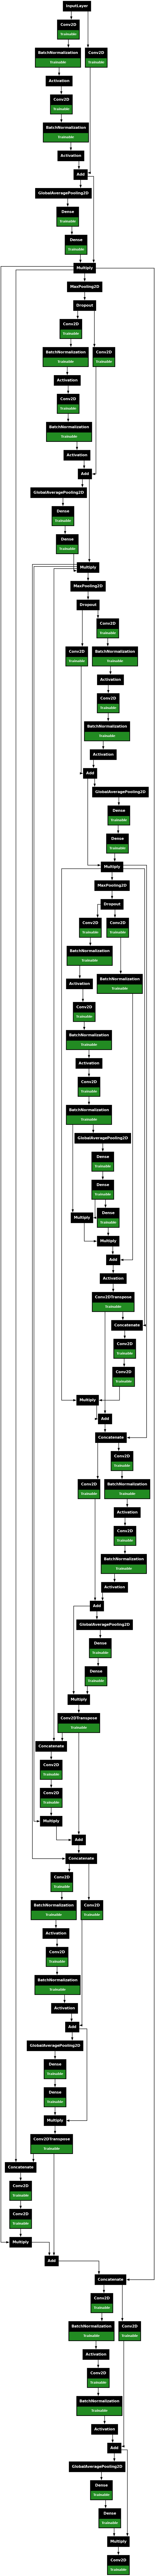

In [ ]:
model = get_unet_model()

# model = dual_unet()



# Print a detailed summary of the model with expanded nested layers and trainable parameters.

model.summary()



# Generate and display a graphical representation of the model architecture.

tfk.utils.plot_model(model, show_trainable=True, expand_nested=False, dpi=70)

#model.save('model.h5')

In [ ]:
# used metric: Mean Intersection Over Union

class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):

    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):

        """

        Custom MeanIoU metric that can exclude certain labels (e.g., background).

        """

        super().__init__(num_classes=num_classes, name=name, dtype=dtype)

        self.labels_to_exclude = labels_to_exclude or []



    def update_state(self, y_true, y_pred, sample_weight=None):

        # Convert predictions to class labels

        y_pred = tf.math.argmax(y_pred, axis=-1)



        # Flatten the tensors

        y_true = tf.reshape(y_true, [-1])

        y_pred = tf.reshape(y_pred, [-1])



        # Apply mask to exclude specified labels

        for label in self.labels_to_exclude:

            mask = tf.not_equal(y_true, label)

            y_true = tf.boolean_mask(y_true, mask)

            y_pred = tf.boolean_mask(y_pred, mask)



        # Update the state

        return super().update_state(y_true, y_pred, sample_weight)

In [ ]:
@register_keras_serializable()

def weighted_sparse_categorical_crossentropy(class_weights):

    def loss(y_true, y_pred):

        class_weights_tensor = tf.constant(list(class_weights.values()), dtype=tf.float32)

        weights = tf.gather(class_weights_tensor, tf.cast(y_true, tf.int32))

        scce = tfk.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

        loss = scce(y_true, y_pred)

        return tf.reduce_mean(loss * weights)

    return loss

In [ ]:
@register_keras_serializable()

def weighted_combined_loss(class_weights, alpha=0.5):

    if class_weights is not None:

        scce_loss = weighted_sparse_categorical_crossentropy(class_weights)

    else:

        scce_loss = tfk.losses.SparseCategoricalCrossentropy()

    dice_loss = tfk.losses.Dice()



    def combined_loss(y_true, y_pred):

        scce = scce_loss(y_true, y_pred)

        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=NUM_CLASSES)

        dice = dice_loss(y_true_one_hot, y_pred)

        return alpha * dice + (1 - alpha) * scce

        return scce



    return combined_loss

In [ ]:
@register_keras_serializable()

def focal_tversky_dice_loss(class_weights=None, alpha=0.5, beta=0.5, gamma=2.0, dice_weight=0.5, tversky_weight=0.5):

    def loss(y_true, y_pred):

        y_pred = tf.nn.softmax(y_pred, axis=-1)

        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=NUM_CLASSES)



        if class_weights is not None:

            class_weights_tensor = tf.constant(list(class_weights.values()), dtype=tf.float32)

            weights = tf.gather(class_weights_tensor, tf.cast(y_true, tf.int32))

        else:

            weights = 1.0 # no weighting



        # Tversky Loss components

        TP_tversky = tf.reduce_sum(weights * y_true * y_pred, axis=[1, 2])

        FP_tversky = tf.reduce_sum(weights * (1 - y_true) * y_pred, axis=[1, 2])

        FN_tversky = tf.reduce_sum(weights * y_true * (1 - y_pred), axis=[1, 2])



        tversky_index = TP_tversky / (TP_tversky + alpha * FP_tversky + beta * FN_tversky + K.epsilon())

        focal_tversky = K.pow((1 - tversky_index), gamma)



        # Dice Loss components

        TP_dice = tf.reduce_sum(weights * y_true * y_pred, axis=[1,2])

        FP_FN_dice = tf.reduce_sum(weights * (y_true + y_pred), axis=[1,2])

        weighted_dice = 1 - (2 * TP_dice) / (FP_FN_dice + K.epsilon())



        # Combine losses

        combined_loss = tversky_weight * tf.reduce_mean(focal_tversky) + dice_weight * tf.reduce_mean(weighted_dice)

        return combined_loss

    return loss

In [ ]:
@register_keras_serializable()

def focal_tversky_loss(class_weights=None, alpha=0.5, beta=0.5, gamma=2.0):

    def loss(y_true, y_pred):

        y_pred = tf.nn.softmax(y_pred, axis=-1)

        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=NUM_CLASSES)



        if class_weights is not None:

            class_weights_tensor = tf.constant(list(class_weights.values()), dtype=tf.float32)

            weights = tf.gather(class_weights_tensor, tf.cast(y_true, tf.int32))

        else:

            weights = 1.0



        TP = tf.reduce_sum(weights * y_true * y_pred, axis=[1, 2])

        FP = tf.reduce_sum(weights * (1 - y_true) * y_pred, axis=[1, 2])

        FN = tf.reduce_sum(weights * y_true * (1 - y_pred), axis=[1, 2])



        tversky_index = TP / (TP + alpha * FP + beta * FN + K.epsilon())

        focal_tversky = K.pow((1 - tversky_index), gamma)

        return tf.reduce_mean(focal_tversky)

    return loss

In [ ]:
@register_keras_serializable()

def masked_focal_tversky_loss(ignore_class, class_weights=None, alpha=0.5, beta=0.5, gamma=2.0):

    def loss(y_true, y_pred):

        y_pred = tf.nn.softmax(y_pred, axis=-1)

        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=NUM_CLASSES)



        # Create a mask to ignore the specific class

        mask = tf.not_equal(tf.argmax(y_true, axis=-1), ignore_class)

        mask = tf.expand_dims(tf.cast(mask, tf.float32), axis=-1)



        # Mask the predictions and ground truth

        y_pred = y_pred * mask

        y_true = y_true * mask



        # Use class weights

        if class_weights is not None:

            class_weights_tensor = tf.constant(list(class_weights.values()), dtype=tf.float32)

            weights = tf.gather(class_weights_tensor, tf.cast(y_true, tf.int32))

        else:

            weights = 1.0



        # Compute Tversky components

        TP = tf.reduce_sum(weights * y_true * y_pred, axis=[1, 2])

        FP = tf.reduce_sum(weights * (1 - y_true) * y_pred, axis=[1, 2])

        FN = tf.reduce_sum(weights * y_true * (1 - y_pred), axis=[1, 2])



        tversky_index = TP / (TP + alpha * FP + beta * FN + K.epsilon())

        focal_tversky = K.pow((1 - tversky_index), gamma)

        return tf.reduce_mean(focal_tversky)

    return loss

In [ ]:
# loss_fn = weighted_combined_loss(class_weights=class_weights, alpha=0.9)

loss_fn = focal_tversky_loss(class_weights=class_weights)

# loss_fn = masked_focal_tversky_loss(ignore_class=4, class_weights=class_weights)



# Compile the model

model.compile(

    loss=loss_fn,

    optimizer=tfk.optimizers.AdamW(1e-4),

    metrics=[tfk.metrics.MeanIoU(num_classes=NUM_CLASSES, ignore_class=0, sparse_y_pred=False, name="mean_iou"), "accuracy"]

)

# Train and Save the Model

In [ ]:
# callback for visualization during training

class VizCallback(tf.keras.callbacks.Callback):

    def __init__(self, X, y, frequency=5):

        """

        Visualization callback to monitor predictions during training.



        Parameters:

        - X: NumPy array of input images.

        - y: NumPy array of ground truth masks.

        - frequency: How often (in epochs) to visualize predictions.

        """

        super().__init__()

        self.X = X

        self.y = y

        self.frequency = frequency



    def on_epoch_end(self, epoch, logs=None):

        if epoch % self.frequency == 0:  # Visualize every "frequency" epochs

            idx = 207  # Select the index of the image to plot

            image = self.X[idx]

            label = self.y[idx]



            # Add batch dimension to the image

            image_input = np.expand_dims(image, axis=0)

            pred = self.model.predict(image_input, verbose=0)

            y_pred = tf.math.argmax(pred, axis=-1).numpy()[0]  # Remove batch dimension



            # Create colormap

            num_classes = len(np.unique(self.y))  # Determine number of classes from the labels

            colormap = create_segmentation_colormap(num_classes)



            plt.figure(figsize=(16, 4))



            # Input image

            plt.subplot(1, 3, 1)

            plt.imshow(image, cmap='gray')

            plt.title("Input Image")

            plt.axis('off')



            # Ground truth

            plt.subplot(1, 3, 2)

            colored_label = apply_colormap(label, colormap)

            plt.imshow(colored_label)

            plt.title("Ground Truth Mask")

            plt.axis('off')



            # Prediction

            plt.subplot(1, 3, 3)

            colored_pred = apply_colormap(y_pred, colormap)

            plt.imshow(colored_pred)

            plt.title("Predicted Mask")

            plt.axis('off')



            add_colormap_legend(colormap, NUM_CLASSES, labels_name)



            plt.tight_layout()

            plt.show()

            plt.close()

In [ ]:
# Setup callbacks

early_stopping = tfk.callbacks.EarlyStopping(monitor='val_mean_iou', patience=20, mode='max', restore_best_weights=True)



cosine_decay_scheduling = tfk.optimizers.schedules.CosineDecay(initial_learning_rate=1e-4, decay_steps=50, alpha=0.01)

def lr_scheduler(epoch, lr):

    return float(cosine_decay_scheduling(epoch))

lr_scheduling = tfk.callbacks.LearningRateScheduler(lr_scheduler)

#lr_scheduling = tfk.callbacks.ReduceLROnPlateau(monitor='val_mean_iou', factor=0.5, patience=15, min_lr=1e-6, min_delta=4e-6)



viz_callback = VizCallback(X_val, y_val, frequency=5)

Epoch 1/200


I0000 00:00:1734136829.357327      72 service.cc:145] XLA service 0x7e1320003fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734136829.357406      72 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734136829.357413      72 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1734136885.227432      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3823 - loss: 70.8236 - mean_iou: 0.1513

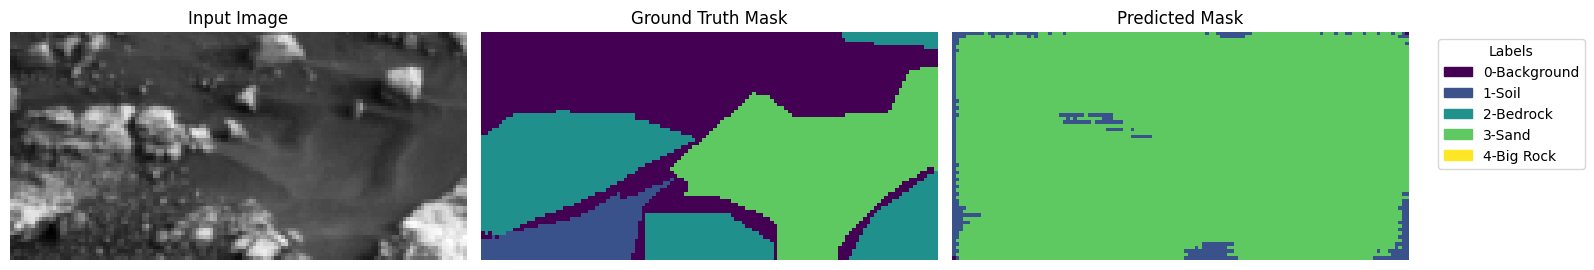

399/399 ━━━━━━━━━━━━━━━━━━━━ 519s 1s/step - accuracy: 0.3824 - loss: 70.7775 - mean_iou: 0.1514 - val_accuracy: 0.2059 - val_loss: 23.7698 - val_mean_iou: 0.0548 - learning_rate: 1.0000e-04
Epoch 2/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 432ms/step - accuracy: 0.5251 - loss: 16.8211 - mean_iou: 0.2445 - val_accuracy: 0.4635 - val_loss: 4.0273 - val_mean_iou: 0.2036 - learning_rate: 9.9902e-05
Epoch 3/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 173s 433ms/step - accuracy: 0.5518 - loss: 2.6317 - mean_iou: 0.2671 - val_accuracy: 0.6126 - val_loss: 0.9828 - val_mean_iou: 0.3253 - learning_rate: 9.9610e-05
Epoch 4/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 432ms/step - accuracy: 0.5550 - loss: 0.8920 - mean_iou: 0.2707 - val_accuracy: 0.5542 - val_loss: 0.8486 - val_mean_iou: 0.2450 - learning_rate: 9.9123e-05
Epoch 5/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 431ms/step - accuracy: 0.5794 - loss: 0.8328 - mean_iou: 0.2898 - val_accuracy: 0.6764 - val_loss: 0.8301 - val_mean_iou: 0.3969 - learning_rate: 9.8445e-

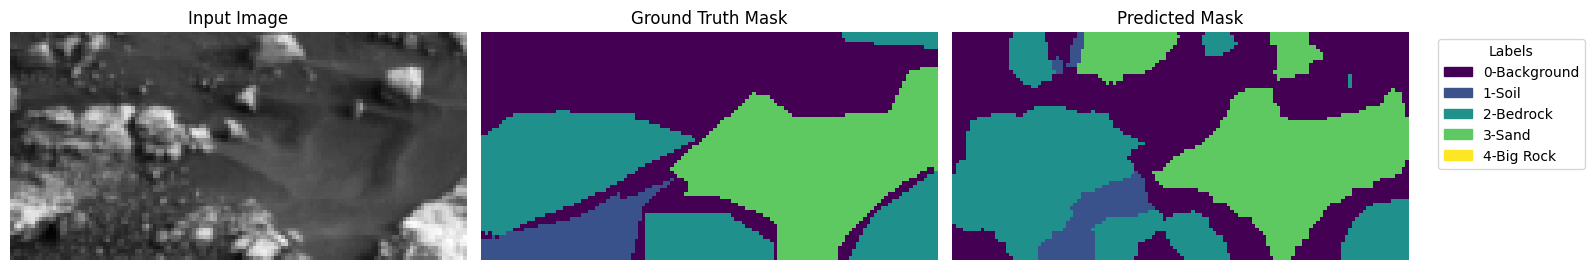

399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 432ms/step - accuracy: 0.5878 - loss: 0.8282 - mean_iou: 0.2957 - val_accuracy: 0.6531 - val_loss: 0.8304 - val_mean_iou: 0.3676 - learning_rate: 9.7577e-05
Epoch 7/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 430ms/step - accuracy: 0.6014 - loss: 0.8244 - mean_iou: 0.3071 - val_accuracy: 0.6119 - val_loss: 0.8325 - val_mean_iou: 0.3142 - learning_rate: 9.6524e-05
Epoch 8/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 256s 641ms/step - accuracy: 0.6136 - loss: 0.8234 - mean_iou: 0.3185 - val_accuracy: 0.6431 - val_loss: 0.8264 - val_mean_iou: 0.3570 - learning_rate: 9.5289e-05
Epoch 9/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 429ms/step - accuracy: 0.6138 - loss: 0.8197 - mean_iou: 0.3194 - val_accuracy: 0.6981 - val_loss: 0.8202 - val_mean_iou: 0.4216 - learning_rate: 9.3877e-05
Epoch 10/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 432ms/step - accuracy: 0.6321 - loss: 0.8169 - mean_iou: 0.3329 - val_accuracy: 0.6669 - val_loss: 0.8222 - val_mean_iou: 0.3827 - learning_rate: 9.2294e

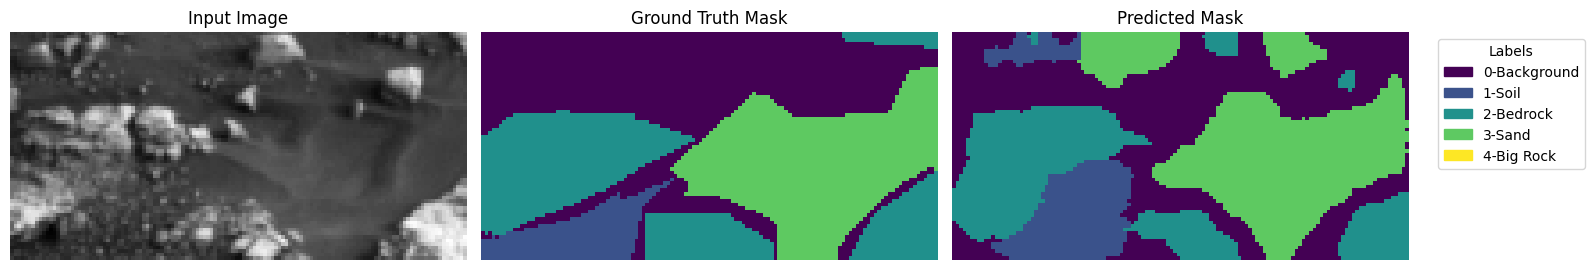

399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 431ms/step - accuracy: 0.6266 - loss: 0.8157 - mean_iou: 0.3279 - val_accuracy: 0.7087 - val_loss: 0.8181 - val_mean_iou: 0.4267 - learning_rate: 9.0546e-05
Epoch 12/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 430ms/step - accuracy: 0.6360 - loss: 0.8149 - mean_iou: 0.3418 - val_accuracy: 0.6820 - val_loss: 0.8182 - val_mean_iou: 0.3880 - learning_rate: 8.8640e-05
Epoch 13/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 432ms/step - accuracy: 0.6423 - loss: 0.8116 - mean_iou: 0.3462 - val_accuracy: 0.6759 - val_loss: 0.8193 - val_mean_iou: 0.3794 - learning_rate: 8.6584e-05
Epoch 14/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 429ms/step - accuracy: 0.6593 - loss: 0.8120 - mean_iou: 0.3557 - val_accuracy: 0.6966 - val_loss: 0.8156 - val_mean_iou: 0.4124 - learning_rate: 8.4385e-05
Epoch 15/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 429ms/step - accuracy: 0.6499 - loss: 0.8105 - mean_iou: 0.3523 - val_accuracy: 0.7172 - val_loss: 0.8122 - val_mean_iou: 0.4303 - learning_rate: 8.20

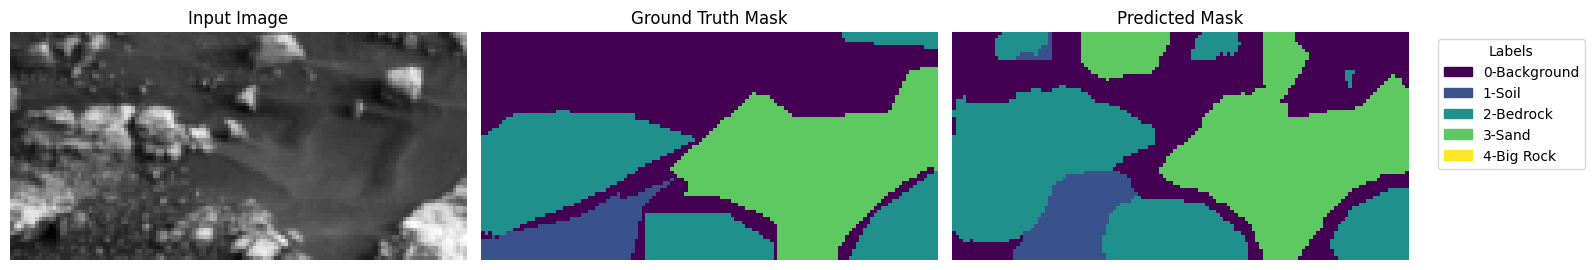

399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 430ms/step - accuracy: 0.6598 - loss: 0.8090 - mean_iou: 0.3621 - val_accuracy: 0.7369 - val_loss: 0.8116 - val_mean_iou: 0.4672 - learning_rate: 7.9595e-05
Epoch 17/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 429ms/step - accuracy: 0.6663 - loss: 0.8062 - mean_iou: 0.3627 - val_accuracy: 0.7023 - val_loss: 0.8127 - val_mean_iou: 0.4159 - learning_rate: 7.7023e-05
Epoch 18/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 429ms/step - accuracy: 0.6678 - loss: 0.8047 - mean_iou: 0.3709 - val_accuracy: 0.7187 - val_loss: 0.8088 - val_mean_iou: 0.4279 - learning_rate: 7.4347e-05
Epoch 19/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 428ms/step - accuracy: 0.6711 - loss: 0.8051 - mean_iou: 0.3673 - val_accuracy: 0.6815 - val_loss: 0.8124 - val_mean_iou: 0.3861 - learning_rate: 7.1576e-05
Epoch 20/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 430ms/step - accuracy: 0.6732 - loss: 0.8024 - mean_iou: 0.3705 - val_accuracy: 0.7168 - val_loss: 0.8074 - val_mean_iou: 0.4337 - learning_rate: 6.87

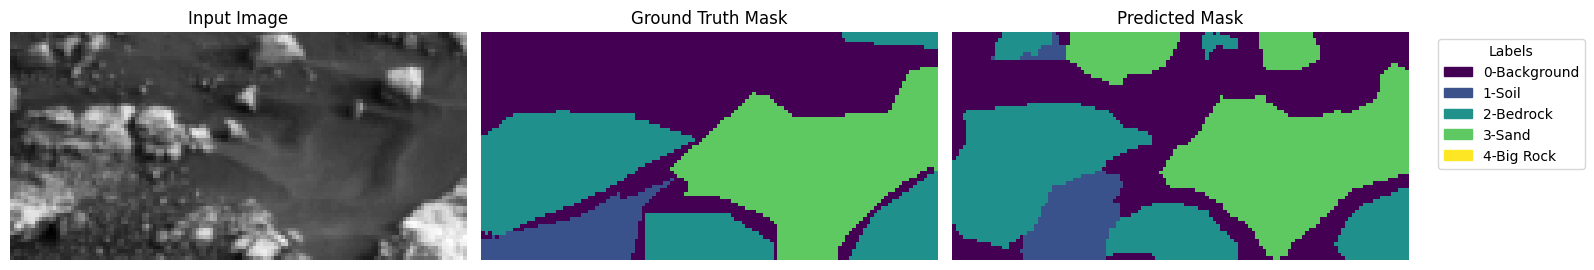

399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 429ms/step - accuracy: 0.6830 - loss: 0.8024 - mean_iou: 0.3809 - val_accuracy: 0.7559 - val_loss: 0.8038 - val_mean_iou: 0.4713 - learning_rate: 6.5796e-05
Epoch 22/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 170s 426ms/step - accuracy: 0.6926 - loss: 0.7998 - mean_iou: 0.3848 - val_accuracy: 0.7399 - val_loss: 0.8045 - val_mean_iou: 0.4636 - learning_rate: 6.2810e-05
Epoch 23/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 203s 509ms/step - accuracy: 0.6807 - loss: 0.7978 - mean_iou: 0.3742 - val_accuracy: 0.7157 - val_loss: 0.8064 - val_mean_iou: 0.4328 - learning_rate: 5.9775e-05
Epoch 24/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 429ms/step - accuracy: 0.6866 - loss: 0.7975 - mean_iou: 0.3852 - val_accuracy: 0.7394 - val_loss: 0.8033 - val_mean_iou: 0.4545 - learning_rate: 5.6704e-05
Epoch 25/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 429ms/step - accuracy: 0.6874 - loss: 0.7966 - mean_iou: 0.3842 - val_accuracy: 0.7293 - val_loss: 0.8017 - val_mean_iou: 0.4361 - learning_rate: 5.36

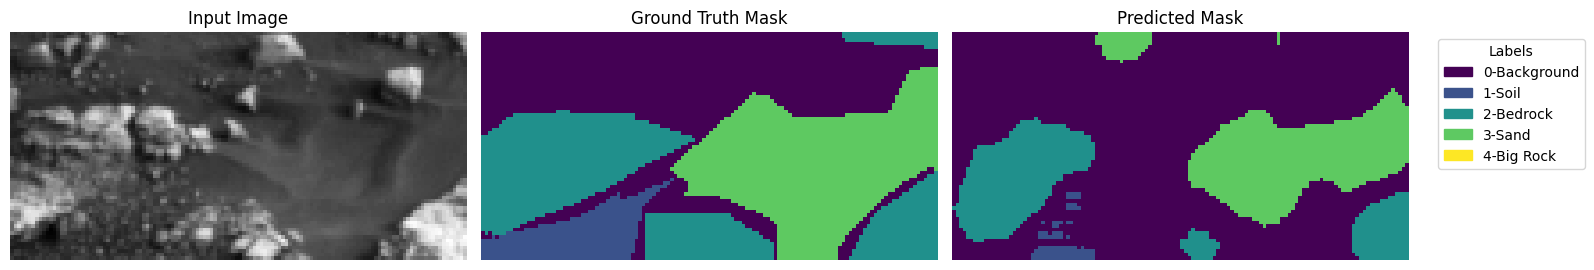

399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 429ms/step - accuracy: 0.6970 - loss: 0.7946 - mean_iou: 0.3854 - val_accuracy: 0.7331 - val_loss: 0.8017 - val_mean_iou: 0.4354 - learning_rate: 5.0500e-05
Epoch 27/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 429ms/step - accuracy: 0.6936 - loss: 0.7959 - mean_iou: 0.3887 - val_accuracy: 0.7476 - val_loss: 0.7982 - val_mean_iou: 0.4654 - learning_rate: 4.7392e-05
Epoch 28/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 428ms/step - accuracy: 0.7046 - loss: 0.7917 - mean_iou: 0.4009 - val_accuracy: 0.7326 - val_loss: 0.8018 - val_mean_iou: 0.4644 - learning_rate: 4.4296e-05
Epoch 29/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 429ms/step - accuracy: 0.7051 - loss: 0.7914 - mean_iou: 0.3969 - val_accuracy: 0.7553 - val_loss: 0.7964 - val_mean_iou: 0.4578 - learning_rate: 4.1225e-05
Epoch 30/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 430ms/step - accuracy: 0.7069 - loss: 0.7894 - mean_iou: 0.3987 - val_accuracy: 0.7626 - val_loss: 0.7956 - val_mean_iou: 0.4716 - learning_rate: 3.81

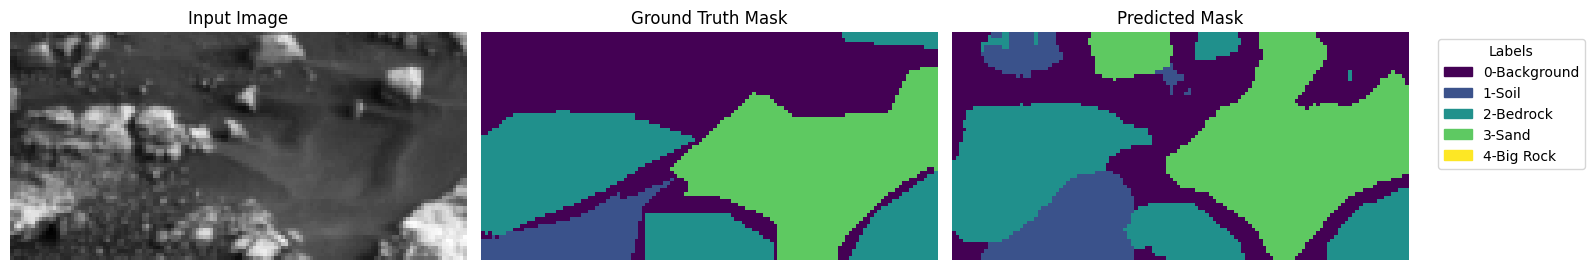

399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 430ms/step - accuracy: 0.7117 - loss: 0.7902 - mean_iou: 0.4021 - val_accuracy: 0.7582 - val_loss: 0.7957 - val_mean_iou: 0.4749 - learning_rate: 3.5204e-05
Epoch 32/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 430ms/step - accuracy: 0.7152 - loss: 0.7888 - mean_iou: 0.4081 - val_accuracy: 0.7414 - val_loss: 0.7958 - val_mean_iou: 0.4546 - learning_rate: 3.2278e-05
Epoch 33/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 430ms/step - accuracy: 0.7154 - loss: 0.7892 - mean_iou: 0.4072 - val_accuracy: 0.7544 - val_loss: 0.7949 - val_mean_iou: 0.4898 - learning_rate: 2.9424e-05
Epoch 34/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 430ms/step - accuracy: 0.7215 - loss: 0.7859 - mean_iou: 0.4132 - val_accuracy: 0.7618 - val_loss: 0.7920 - val_mean_iou: 0.4648 - learning_rate: 2.6653e-05
Epoch 35/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 429ms/step - accuracy: 0.7232 - loss: 0.7837 - mean_iou: 0.4085 - val_accuracy: 0.7568 - val_loss: 0.7929 - val_mean_iou: 0.4669 - learning_rate: 2.39

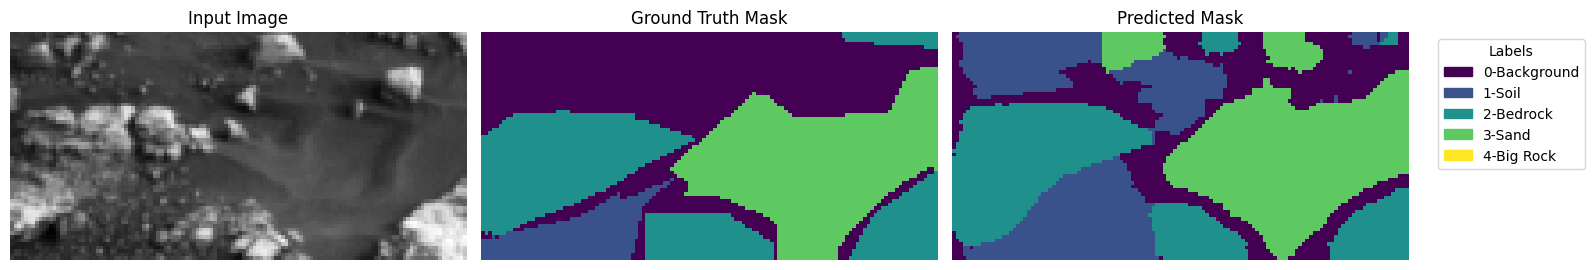

399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 431ms/step - accuracy: 0.7240 - loss: 0.7845 - mean_iou: 0.4145 - val_accuracy: 0.7483 - val_loss: 0.7926 - val_mean_iou: 0.4748 - learning_rate: 2.1405e-05
Epoch 37/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 428ms/step - accuracy: 0.7272 - loss: 0.7851 - mean_iou: 0.4147 - val_accuracy: 0.7663 - val_loss: 0.7894 - val_mean_iou: 0.4836 - learning_rate: 1.8948e-05
Epoch 38/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 430ms/step - accuracy: 0.7312 - loss: 0.7802 - mean_iou: 0.4215 - val_accuracy: 0.7660 - val_loss: 0.7886 - val_mean_iou: 0.4669 - learning_rate: 1.6615e-05
Epoch 39/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 429ms/step - accuracy: 0.7374 - loss: 0.7806 - mean_iou: 0.4224 - val_accuracy: 0.7800 - val_loss: 0.7869 - val_mean_iou: 0.4816 - learning_rate: 1.4416e-05
Epoch 40/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 428ms/step - accuracy: 0.7398 - loss: 0.7800 - mean_iou: 0.4265 - val_accuracy: 0.7777 - val_loss: 0.7864 - val_mean_iou: 0.4886 - learning_rate: 1.23

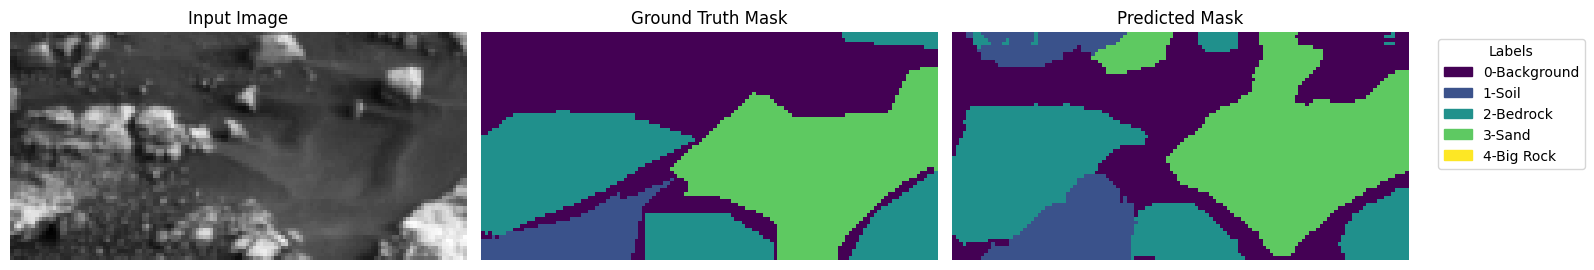

399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 430ms/step - accuracy: 0.7395 - loss: 0.7795 - mean_iou: 0.4286 - val_accuracy: 0.7856 - val_loss: 0.7853 - val_mean_iou: 0.4884 - learning_rate: 1.0454e-05
Epoch 42/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 429ms/step - accuracy: 0.7473 - loss: 0.7786 - mean_iou: 0.4314 - val_accuracy: 0.7815 - val_loss: 0.7859 - val_mean_iou: 0.4914 - learning_rate: 8.7058e-06
Epoch 43/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 430ms/step - accuracy: 0.7453 - loss: 0.7773 - mean_iou: 0.4283 - val_accuracy: 0.7821 - val_loss: 0.7850 - val_mean_iou: 0.4897 - learning_rate: 7.1228e-06
Epoch 44/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 430ms/step - accuracy: 0.7488 - loss: 0.7771 - mean_iou: 0.4341 - val_accuracy: 0.7853 - val_loss: 0.7843 - val_mean_iou: 0.4936 - learning_rate: 5.7111e-06
Epoch 45/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 429ms/step - accuracy: 0.7526 - loss: 0.7768 - mean_iou: 0.4364 - val_accuracy: 0.7886 - val_loss: 0.7834 - val_mean_iou: 0.4984 - learning_rate: 4.47

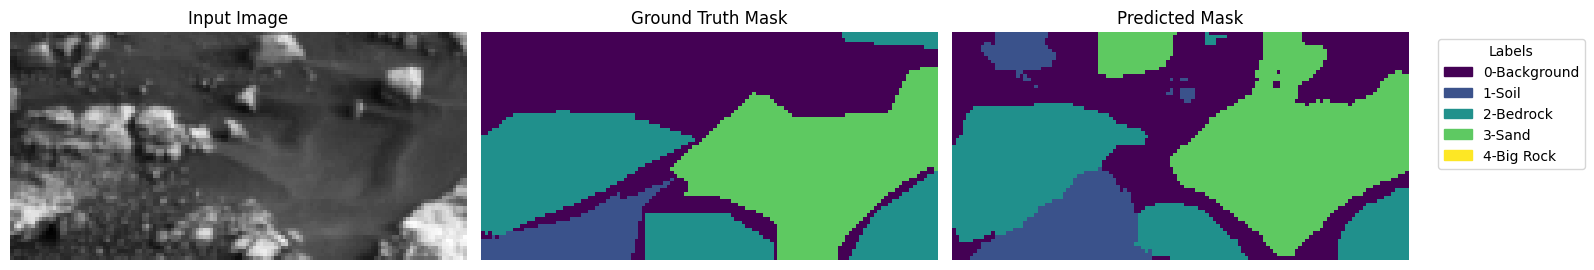

399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 431ms/step - accuracy: 0.7528 - loss: 0.7760 - mean_iou: 0.4385 - val_accuracy: 0.7932 - val_loss: 0.7827 - val_mean_iou: 0.4956 - learning_rate: 3.4227e-06
Epoch 47/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 429ms/step - accuracy: 0.7557 - loss: 0.7754 - mean_iou: 0.4367 - val_accuracy: 0.7933 - val_loss: 0.7823 - val_mean_iou: 0.4968 - learning_rate: 2.5551e-06
Epoch 48/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 257s 646ms/step - accuracy: 0.7602 - loss: 0.7757 - mean_iou: 0.4422 - val_accuracy: 0.7910 - val_loss: 0.7824 - val_mean_iou: 0.4948 - learning_rate: 1.8768e-06
Epoch 49/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 429ms/step - accuracy: 0.7671 - loss: 0.7743 - mean_iou: 0.4479 - val_accuracy: 0.7922 - val_loss: 0.7819 - val_mean_iou: 0.4943 - learning_rate: 1.3903e-06
Epoch 50/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 430ms/step - accuracy: 0.7600 - loss: 0.7732 - mean_iou: 0.4454 - val_accuracy: 0.7916 - val_loss: 0.7819 - val_mean_iou: 0.4957 - learning_rate: 1.09

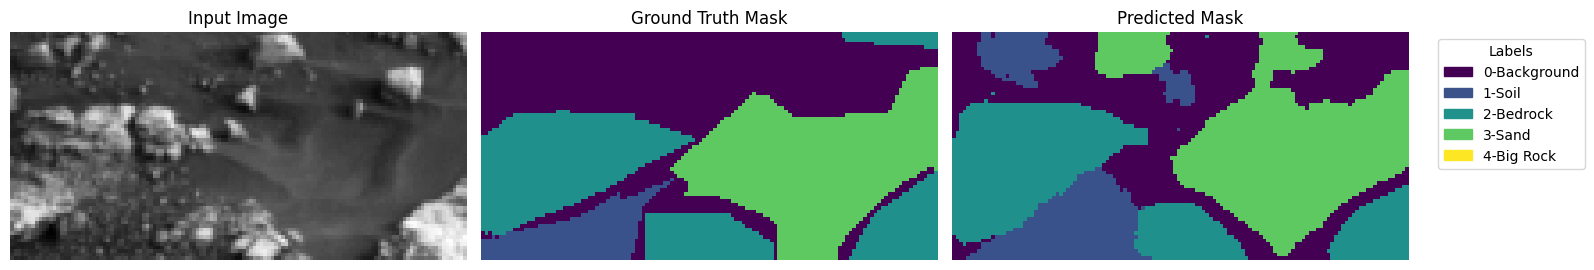

399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 432ms/step - accuracy: 0.7585 - loss: 0.7740 - mean_iou: 0.4418 - val_accuracy: 0.7917 - val_loss: 0.7819 - val_mean_iou: 0.4966 - learning_rate: 1.0000e-06
Epoch 52/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 430ms/step - accuracy: 0.7624 - loss: 0.7753 - mean_iou: 0.4452 - val_accuracy: 0.7939 - val_loss: 0.7817 - val_mean_iou: 0.4987 - learning_rate: 1.0000e-06
Epoch 53/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 430ms/step - accuracy: 0.7640 - loss: 0.7739 - mean_iou: 0.4451 - val_accuracy: 0.7914 - val_loss: 0.7817 - val_mean_iou: 0.4951 - learning_rate: 1.0000e-06
Epoch 54/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 432ms/step - accuracy: 0.7607 - loss: 0.7735 - mean_iou: 0.4421 - val_accuracy: 0.7894 - val_loss: 0.7820 - val_mean_iou: 0.4966 - learning_rate: 1.0000e-06
Epoch 55/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 428ms/step - accuracy: 0.7659 - loss: 0.7739 - mean_iou: 0.4494 - val_accuracy: 0.7945 - val_loss: 0.7815 - val_mean_iou: 0.5005 - learning_rate: 1.00

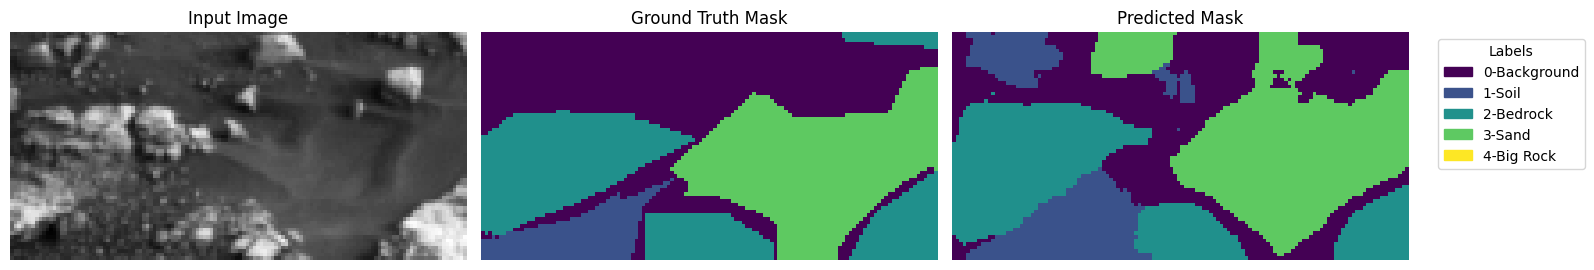

399/399 ━━━━━━━━━━━━━━━━━━━━ 173s 432ms/step - accuracy: 0.7615 - loss: 0.7730 - mean_iou: 0.4438 - val_accuracy: 0.7939 - val_loss: 0.7816 - val_mean_iou: 0.4991 - learning_rate: 1.0000e-06
Epoch 57/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 428ms/step - accuracy: 0.7643 - loss: 0.7743 - mean_iou: 0.4464 - val_accuracy: 0.7927 - val_loss: 0.7815 - val_mean_iou: 0.4963 - learning_rate: 1.0000e-06
Epoch 58/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 173s 433ms/step - accuracy: 0.7678 - loss: 0.7739 - mean_iou: 0.4459 - val_accuracy: 0.7923 - val_loss: 0.7817 - val_mean_iou: 0.4971 - learning_rate: 1.0000e-06
Epoch 59/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 429ms/step - accuracy: 0.7641 - loss: 0.7739 - mean_iou: 0.4442 - val_accuracy: 0.7932 - val_loss: 0.7816 - val_mean_iou: 0.4966 - learning_rate: 1.0000e-06
Epoch 60/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 430ms/step - accuracy: 0.7647 - loss: 0.7739 - mean_iou: 0.4455 - val_accuracy: 0.7929 - val_loss: 0.7817 - val_mean_iou: 0.4959 - learning_rate: 1.00

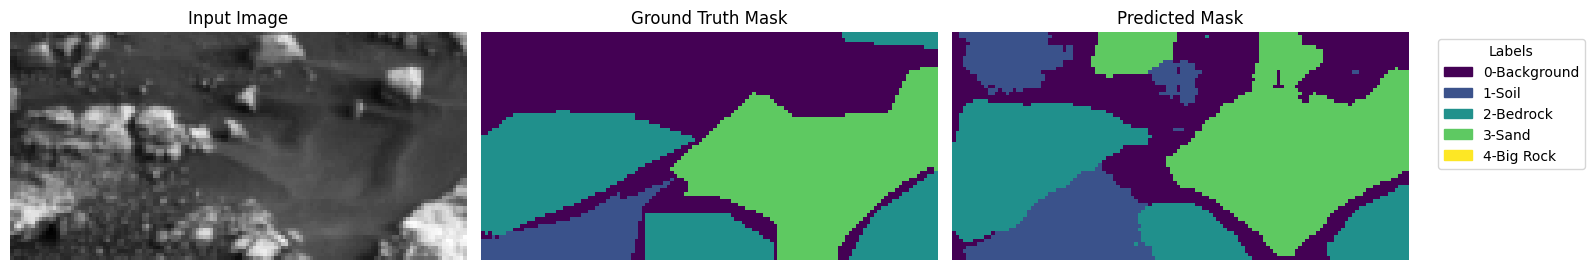

399/399 ━━━━━━━━━━━━━━━━━━━━ 173s 433ms/step - accuracy: 0.7569 - loss: 0.7734 - mean_iou: 0.4402 - val_accuracy: 0.7925 - val_loss: 0.7817 - val_mean_iou: 0.4993 - learning_rate: 1.0000e-06
Epoch 62/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 430ms/step - accuracy: 0.7692 - loss: 0.7731 - mean_iou: 0.4475 - val_accuracy: 0.7962 - val_loss: 0.7815 - val_mean_iou: 0.4994 - learning_rate: 1.0000e-06
Epoch 63/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 430ms/step - accuracy: 0.7679 - loss: 0.7725 - mean_iou: 0.4444 - val_accuracy: 0.7939 - val_loss: 0.7817 - val_mean_iou: 0.4974 - learning_rate: 1.0000e-06
Epoch 64/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 432ms/step - accuracy: 0.7716 - loss: 0.7728 - mean_iou: 0.4478 - val_accuracy: 0.7926 - val_loss: 0.7817 - val_mean_iou: 0.4937 - learning_rate: 1.0000e-06
Epoch 65/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 430ms/step - accuracy: 0.7698 - loss: 0.7742 - mean_iou: 0.4504 - val_accuracy: 0.7946 - val_loss: 0.7816 - val_mean_iou: 0.4949 - learning_rate: 1.00

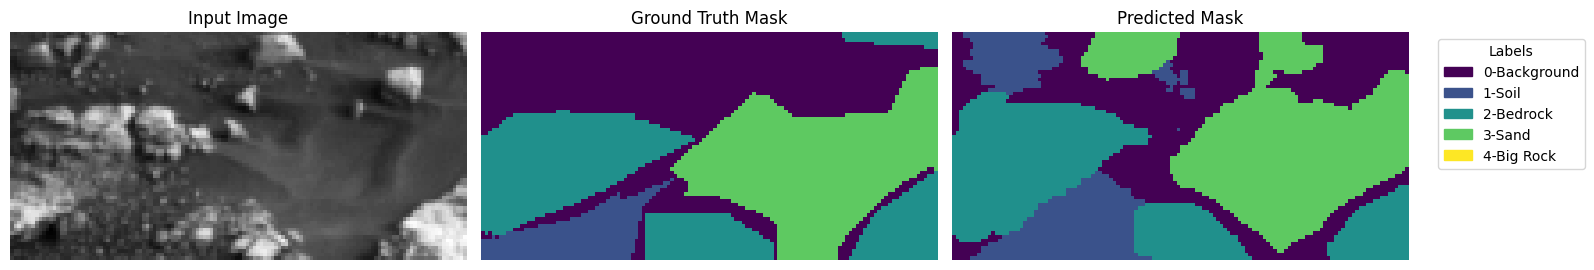

399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 432ms/step - accuracy: 0.7688 - loss: 0.7737 - mean_iou: 0.4503 - val_accuracy: 0.7904 - val_loss: 0.7822 - val_mean_iou: 0.4955 - learning_rate: 1.0000e-06
Epoch 67/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 431ms/step - accuracy: 0.7752 - loss: 0.7736 - mean_iou: 0.4492 - val_accuracy: 0.7972 - val_loss: 0.7814 - val_mean_iou: 0.5004 - learning_rate: 1.0000e-06
Epoch 68/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 430ms/step - accuracy: 0.7728 - loss: 0.7746 - mean_iou: 0.4486 - val_accuracy: 0.7915 - val_loss: 0.7823 - val_mean_iou: 0.4981 - learning_rate: 1.0000e-06
Epoch 69/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 432ms/step - accuracy: 0.7689 - loss: 0.7719 - mean_iou: 0.4470 - val_accuracy: 0.7945 - val_loss: 0.7814 - val_mean_iou: 0.4995 - learning_rate: 1.0000e-06
Epoch 70/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 431ms/step - accuracy: 0.7676 - loss: 0.7718 - mean_iou: 0.4468 - val_accuracy: 0.7952 - val_loss: 0.7814 - val_mean_iou: 0.4969 - learning_rate: 1.00

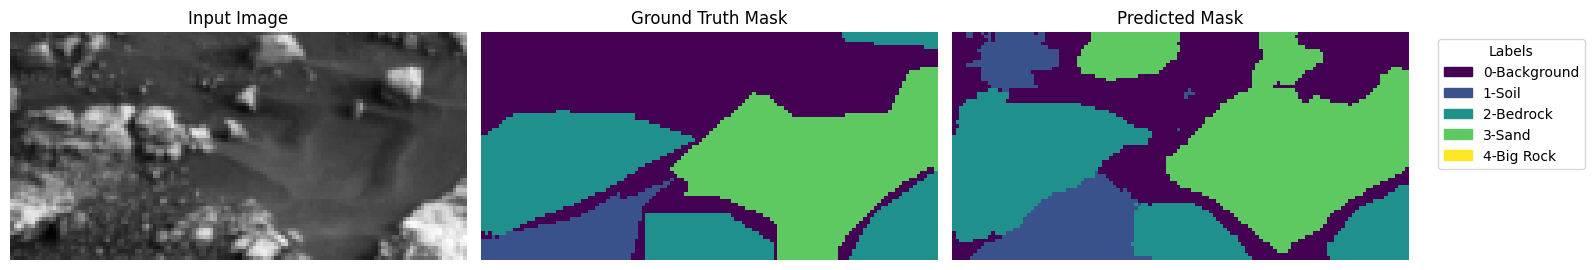

399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 431ms/step - accuracy: 0.7706 - loss: 0.7750 - mean_iou: 0.4480 - val_accuracy: 0.7947 - val_loss: 0.7817 - val_mean_iou: 0.4995 - learning_rate: 1.0000e-06
Epoch 72/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 431ms/step - accuracy: 0.7700 - loss: 0.7727 - mean_iou: 0.4492 - val_accuracy: 0.7963 - val_loss: 0.7815 - val_mean_iou: 0.5014 - learning_rate: 1.0000e-06
Epoch 73/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 432ms/step - accuracy: 0.7701 - loss: 0.7728 - mean_iou: 0.4473 - val_accuracy: 0.7914 - val_loss: 0.7817 - val_mean_iou: 0.4949 - learning_rate: 1.0000e-06
Epoch 74/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 430ms/step - accuracy: 0.7738 - loss: 0.7729 - mean_iou: 0.4478 - val_accuracy: 0.7969 - val_loss: 0.7814 - val_mean_iou: 0.4999 - learning_rate: 1.0000e-06
Epoch 75/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 430ms/step - accuracy: 0.7706 - loss: 0.7721 - mean_iou: 0.4478 - val_accuracy: 0.7928 - val_loss: 0.7816 - val_mean_iou: 0.4955 - learning_rate: 1.00

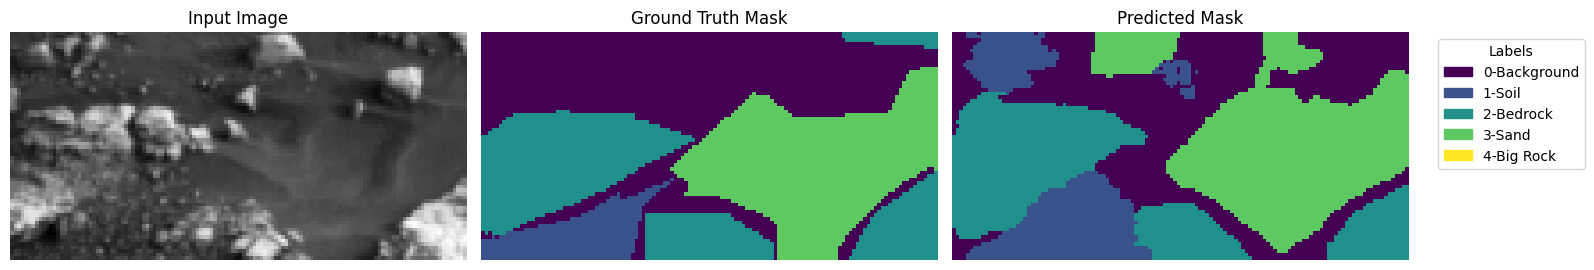

399/399 ━━━━━━━━━━━━━━━━━━━━ 173s 433ms/step - accuracy: 0.7712 - loss: 0.7725 - mean_iou: 0.4477 - val_accuracy: 0.7936 - val_loss: 0.7814 - val_mean_iou: 0.4948 - learning_rate: 1.0000e-06
Epoch 77/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 428ms/step - accuracy: 0.7744 - loss: 0.7739 - mean_iou: 0.4512 - val_accuracy: 0.7979 - val_loss: 0.7811 - val_mean_iou: 0.4992 - learning_rate: 1.0000e-06
Epoch 78/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 432ms/step - accuracy: 0.7757 - loss: 0.7728 - mean_iou: 0.4510 - val_accuracy: 0.7965 - val_loss: 0.7815 - val_mean_iou: 0.4979 - learning_rate: 1.0000e-06
Epoch 79/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 432ms/step - accuracy: 0.7699 - loss: 0.7720 - mean_iou: 0.4478 - val_accuracy: 0.7966 - val_loss: 0.7813 - val_mean_iou: 0.5009 - learning_rate: 1.0000e-06
Epoch 80/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 431ms/step - accuracy: 0.7714 - loss: 0.7727 - mean_iou: 0.4505 - val_accuracy: 0.7989 - val_loss: 0.7813 - val_mean_iou: 0.5016 - learning_rate: 1.00

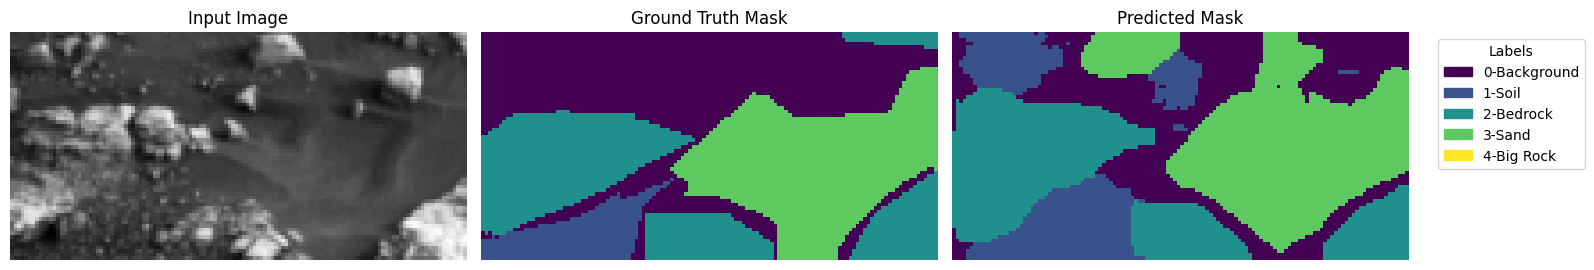

399/399 ━━━━━━━━━━━━━━━━━━━━ 173s 433ms/step - accuracy: 0.7710 - loss: 0.7724 - mean_iou: 0.4485 - val_accuracy: 0.7910 - val_loss: 0.7819 - val_mean_iou: 0.4974 - learning_rate: 1.0000e-06
Epoch 82/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 430ms/step - accuracy: 0.7758 - loss: 0.7744 - mean_iou: 0.4520 - val_accuracy: 0.7936 - val_loss: 0.7818 - val_mean_iou: 0.4996 - learning_rate: 1.0000e-06
Epoch 83/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 431ms/step - accuracy: 0.7750 - loss: 0.7732 - mean_iou: 0.4508 - val_accuracy: 0.7877 - val_loss: 0.7822 - val_mean_iou: 0.4918 - learning_rate: 1.0000e-06
Epoch 84/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 431ms/step - accuracy: 0.7709 - loss: 0.7742 - mean_iou: 0.4492 - val_accuracy: 0.7960 - val_loss: 0.7813 - val_mean_iou: 0.4989 - learning_rate: 1.0000e-06
Epoch 85/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 432ms/step - accuracy: 0.7755 - loss: 0.7726 - mean_iou: 0.4517 - val_accuracy: 0.7935 - val_loss: 0.7818 - val_mean_iou: 0.5001 - learning_rate: 1.00

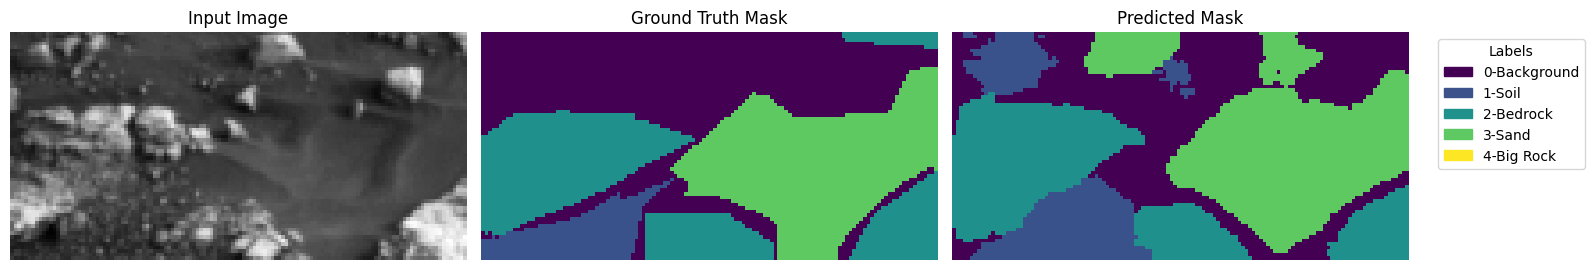

399/399 ━━━━━━━━━━━━━━━━━━━━ 173s 433ms/step - accuracy: 0.7751 - loss: 0.7731 - mean_iou: 0.4497 - val_accuracy: 0.7953 - val_loss: 0.7814 - val_mean_iou: 0.4942 - learning_rate: 1.0000e-06
Epoch 87/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 432ms/step - accuracy: 0.7752 - loss: 0.7714 - mean_iou: 0.4522 - val_accuracy: 0.7989 - val_loss: 0.7810 - val_mean_iou: 0.5006 - learning_rate: 1.0000e-06
Epoch 88/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 431ms/step - accuracy: 0.7789 - loss: 0.7720 - mean_iou: 0.4515 - val_accuracy: 0.7962 - val_loss: 0.7813 - val_mean_iou: 0.5006 - learning_rate: 1.0000e-06
Epoch 89/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 432ms/step - accuracy: 0.7775 - loss: 0.7722 - mean_iou: 0.4529 - val_accuracy: 0.7956 - val_loss: 0.7816 - val_mean_iou: 0.4972 - learning_rate: 1.0000e-06
Epoch 90/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 173s 432ms/step - accuracy: 0.7773 - loss: 0.7732 - mean_iou: 0.4514 - val_accuracy: 0.7992 - val_loss: 0.7810 - val_mean_iou: 0.5008 - learning_rate: 1.00

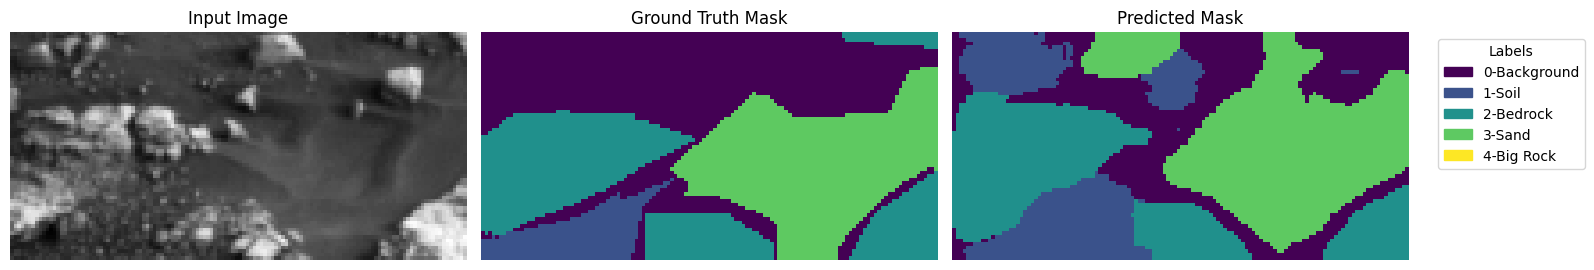

399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 432ms/step - accuracy: 0.7802 - loss: 0.7723 - mean_iou: 0.4563 - val_accuracy: 0.7951 - val_loss: 0.7814 - val_mean_iou: 0.5038 - learning_rate: 1.0000e-06
Epoch 92/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 432ms/step - accuracy: 0.7750 - loss: 0.7717 - mean_iou: 0.4510 - val_accuracy: 0.7960 - val_loss: 0.7815 - val_mean_iou: 0.5012 - learning_rate: 1.0000e-06
Epoch 93/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 431ms/step - accuracy: 0.7754 - loss: 0.7723 - mean_iou: 0.4545 - val_accuracy: 0.7948 - val_loss: 0.7813 - val_mean_iou: 0.4965 - learning_rate: 1.0000e-06
Epoch 94/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 173s 432ms/step - accuracy: 0.7796 - loss: 0.7712 - mean_iou: 0.4509 - val_accuracy: 0.7956 - val_loss: 0.7812 - val_mean_iou: 0.4946 - learning_rate: 1.0000e-06
Epoch 95/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 430ms/step - accuracy: 0.7757 - loss: 0.7718 - mean_iou: 0.4520 - val_accuracy: 0.7947 - val_loss: 0.7813 - val_mean_iou: 0.4961 - learning_rate: 1.00

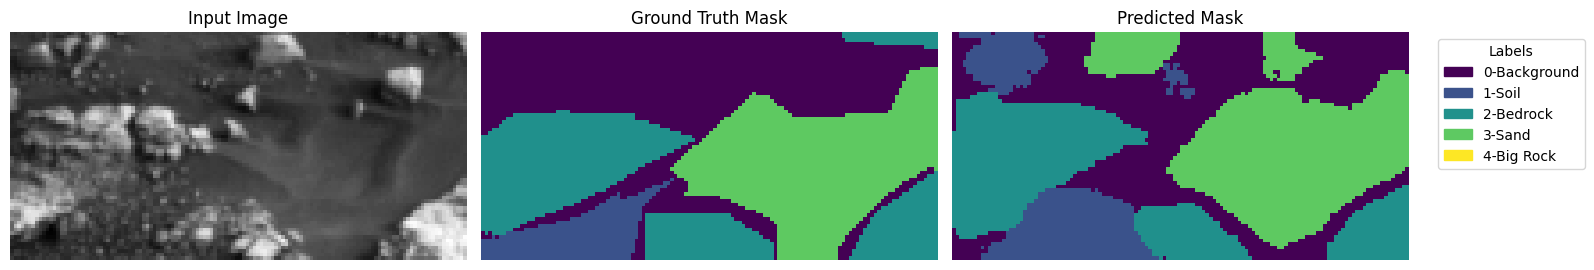

399/399 ━━━━━━━━━━━━━━━━━━━━ 173s 433ms/step - accuracy: 0.7752 - loss: 0.7724 - mean_iou: 0.4523 - val_accuracy: 0.7946 - val_loss: 0.7814 - val_mean_iou: 0.4936 - learning_rate: 1.0000e-06
Epoch 97/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 431ms/step - accuracy: 0.7817 - loss: 0.7715 - mean_iou: 0.4541 - val_accuracy: 0.7985 - val_loss: 0.7810 - val_mean_iou: 0.5018 - learning_rate: 1.0000e-06
Epoch 98/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 173s 433ms/step - accuracy: 0.7776 - loss: 0.7726 - mean_iou: 0.4528 - val_accuracy: 0.7944 - val_loss: 0.7815 - val_mean_iou: 0.4971 - learning_rate: 1.0000e-06
Epoch 99/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 430ms/step - accuracy: 0.7789 - loss: 0.7715 - mean_iou: 0.4523 - val_accuracy: 0.7956 - val_loss: 0.7811 - val_mean_iou: 0.4982 - learning_rate: 1.0000e-06
Epoch 100/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 432ms/step - accuracy: 0.7853 - loss: 0.7721 - mean_iou: 0.4585 - val_accuracy: 0.7949 - val_loss: 0.7812 - val_mean_iou: 0.4977 - learning_rate: 1.0

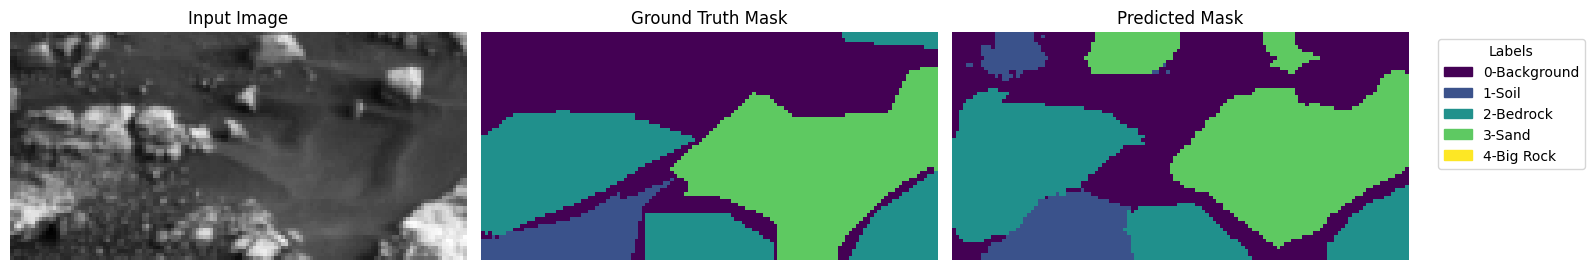

399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 432ms/step - accuracy: 0.7797 - loss: 0.7725 - mean_iou: 0.4553 - val_accuracy: 0.7960 - val_loss: 0.7812 - val_mean_iou: 0.4944 - learning_rate: 1.0000e-06
Epoch 102/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 431ms/step - accuracy: 0.7813 - loss: 0.7715 - mean_iou: 0.4548 - val_accuracy: 0.7957 - val_loss: 0.7813 - val_mean_iou: 0.4994 - learning_rate: 1.0000e-06
Epoch 103/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 173s 433ms/step - accuracy: 0.7745 - loss: 0.7702 - mean_iou: 0.4495 - val_accuracy: 0.7988 - val_loss: 0.7814 - val_mean_iou: 0.5054 - learning_rate: 1.0000e-06
Epoch 104/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 173s 433ms/step - accuracy: 0.7841 - loss: 0.7703 - mean_iou: 0.4581 - val_accuracy: 0.8011 - val_loss: 0.7816 - val_mean_iou: 0.5105 - learning_rate: 1.0000e-06
Epoch 105/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 431ms/step - accuracy: 0.7787 - loss: 0.7720 - mean_iou: 0.4564 - val_accuracy: 0.7962 - val_loss: 0.7813 - val_mean_iou: 0.4996 - learning_rate: 

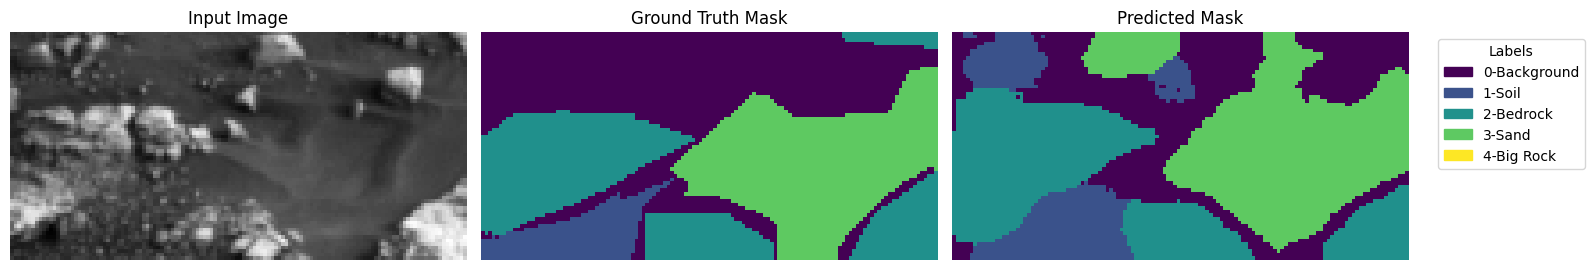

399/399 ━━━━━━━━━━━━━━━━━━━━ 173s 433ms/step - accuracy: 0.7780 - loss: 0.7745 - mean_iou: 0.4543 - val_accuracy: 0.7934 - val_loss: 0.7816 - val_mean_iou: 0.4995 - learning_rate: 1.0000e-06
Epoch 107/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 431ms/step - accuracy: 0.7822 - loss: 0.7721 - mean_iou: 0.4539 - val_accuracy: 0.7985 - val_loss: 0.7813 - val_mean_iou: 0.5011 - learning_rate: 1.0000e-06
Epoch 108/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 173s 433ms/step - accuracy: 0.7828 - loss: 0.7726 - mean_iou: 0.4574 - val_accuracy: 0.8018 - val_loss: 0.7812 - val_mean_iou: 0.5078 - learning_rate: 1.0000e-06
Epoch 109/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 432ms/step - accuracy: 0.7830 - loss: 0.7713 - mean_iou: 0.4563 - val_accuracy: 0.7889 - val_loss: 0.7818 - val_mean_iou: 0.4903 - learning_rate: 1.0000e-06
Epoch 110/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 431ms/step - accuracy: 0.7817 - loss: 0.7735 - mean_iou: 0.4511 - val_accuracy: 0.7896 - val_loss: 0.7821 - val_mean_iou: 0.4941 - learning_rate: 

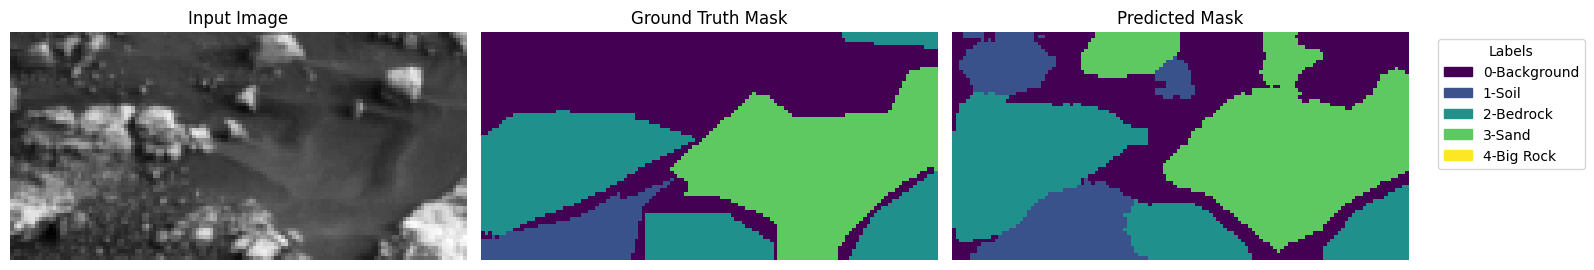

399/399 ━━━━━━━━━━━━━━━━━━━━ 173s 433ms/step - accuracy: 0.7781 - loss: 0.7714 - mean_iou: 0.4541 - val_accuracy: 0.7946 - val_loss: 0.7812 - val_mean_iou: 0.4965 - learning_rate: 1.0000e-06
Epoch 112/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 430ms/step - accuracy: 0.7823 - loss: 0.7713 - mean_iou: 0.4569 - val_accuracy: 0.7903 - val_loss: 0.7820 - val_mean_iou: 0.4893 - learning_rate: 1.0000e-06
Epoch 113/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 432ms/step - accuracy: 0.7813 - loss: 0.7708 - mean_iou: 0.4560 - val_accuracy: 0.7902 - val_loss: 0.7820 - val_mean_iou: 0.4903 - learning_rate: 1.0000e-06
Epoch 114/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 430ms/step - accuracy: 0.7844 - loss: 0.7718 - mean_iou: 0.4564 - val_accuracy: 0.7968 - val_loss: 0.7811 - val_mean_iou: 0.4967 - learning_rate: 1.0000e-06
Epoch 115/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 430ms/step - accuracy: 0.7874 - loss: 0.7721 - mean_iou: 0.4585 - val_accuracy: 0.7973 - val_loss: 0.7812 - val_mean_iou: 0.4995 - learning_rate: 

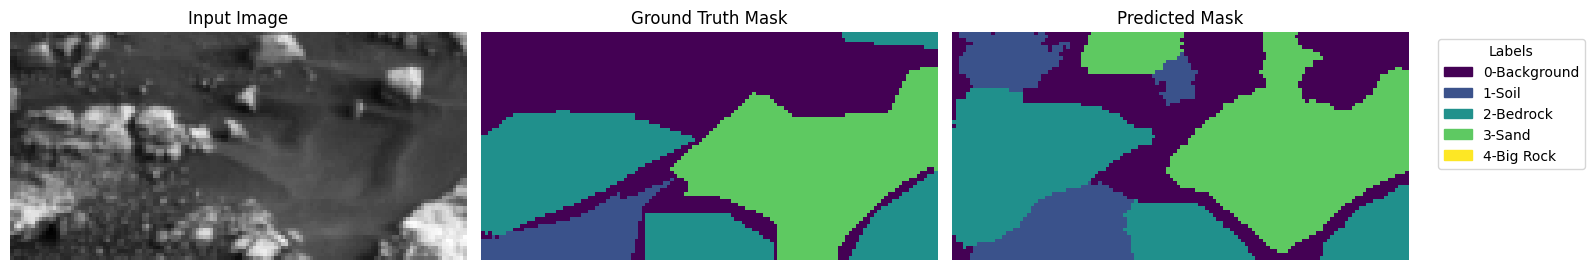

399/399 ━━━━━━━━━━━━━━━━━━━━ 173s 432ms/step - accuracy: 0.7824 - loss: 0.7714 - mean_iou: 0.4549 - val_accuracy: 0.7984 - val_loss: 0.7815 - val_mean_iou: 0.5037 - learning_rate: 1.0000e-06
Epoch 117/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 431ms/step - accuracy: 0.7820 - loss: 0.7714 - mean_iou: 0.4544 - val_accuracy: 0.7919 - val_loss: 0.7818 - val_mean_iou: 0.4917 - learning_rate: 1.0000e-06
Epoch 118/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 430ms/step - accuracy: 0.7844 - loss: 0.7694 - mean_iou: 0.4555 - val_accuracy: 0.7960 - val_loss: 0.7813 - val_mean_iou: 0.4959 - learning_rate: 1.0000e-06
Epoch 119/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 431ms/step - accuracy: 0.7816 - loss: 0.7714 - mean_iou: 0.4524 - val_accuracy: 0.8021 - val_loss: 0.7809 - val_mean_iou: 0.5059 - learning_rate: 1.0000e-06
Epoch 120/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 431ms/step - accuracy: 0.7873 - loss: 0.7711 - mean_iou: 0.4582 - val_accuracy: 0.8010 - val_loss: 0.7813 - val_mean_iou: 0.5073 - learning_rate: 

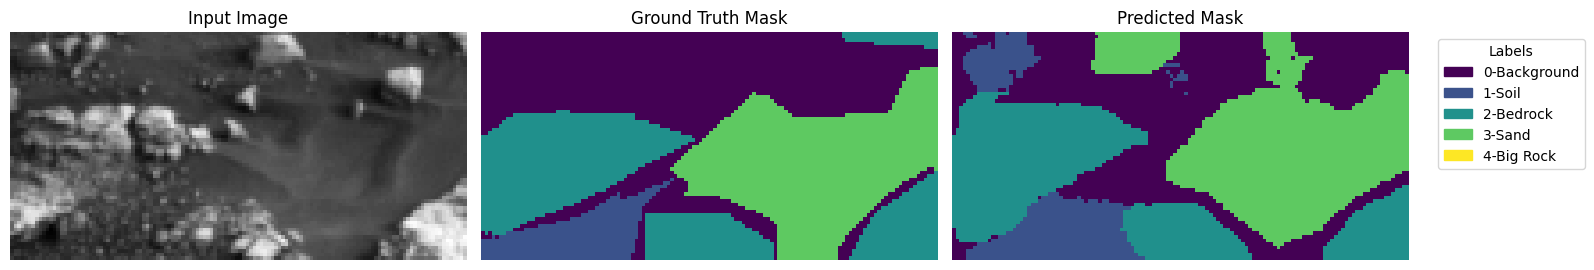

399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 430ms/step - accuracy: 0.7892 - loss: 0.7714 - mean_iou: 0.4574 - val_accuracy: 0.7935 - val_loss: 0.7816 - val_mean_iou: 0.4897 - learning_rate: 1.0000e-06
Epoch 122/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 171s 430ms/step - accuracy: 0.7846 - loss: 0.7718 - mean_iou: 0.4545 - val_accuracy: 0.7843 - val_loss: 0.7822 - val_mean_iou: 0.4877 - learning_rate: 1.0000e-06
Epoch 123/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 432ms/step - accuracy: 0.7821 - loss: 0.7707 - mean_iou: 0.4519 - val_accuracy: 0.7984 - val_loss: 0.7814 - val_mean_iou: 0.4979 - learning_rate: 1.0000e-06
Epoch 124/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 430ms/step - accuracy: 0.7876 - loss: 0.7709 - mean_iou: 0.4562 - val_accuracy: 0.7991 - val_loss: 0.7813 - val_mean_iou: 0.5035 - learning_rate: 1.0000e-06
Final validation Mean Intersection Over Union: 51.05 %


In [ ]:
# Train the model

num_augmentations = 3

batch_size = 16



history = model.fit(

    #X_train, y_train,

    data_generator(X_train, y_train, batch_size=batch_size, num_augmentations=num_augmentations),

    steps_per_epoch=(len(X_train) * num_augmentations) // batch_size,

    epochs=200,

    validation_data=(X_val, y_val),

    callbacks=[early_stopping, lr_scheduling, viz_callback],

    verbose=1

).history



# Calculate and print the final validation Mean Intersection Over Union

final_val_mean_iou = round(max(history['val_mean_iou'])* 100, 2)

print(f'Final validation Mean Intersection Over Union: {final_val_mean_iou} %')

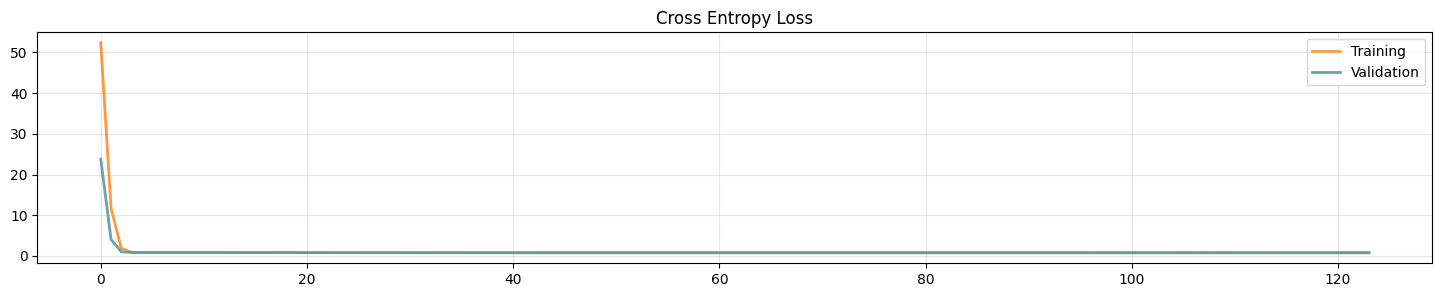

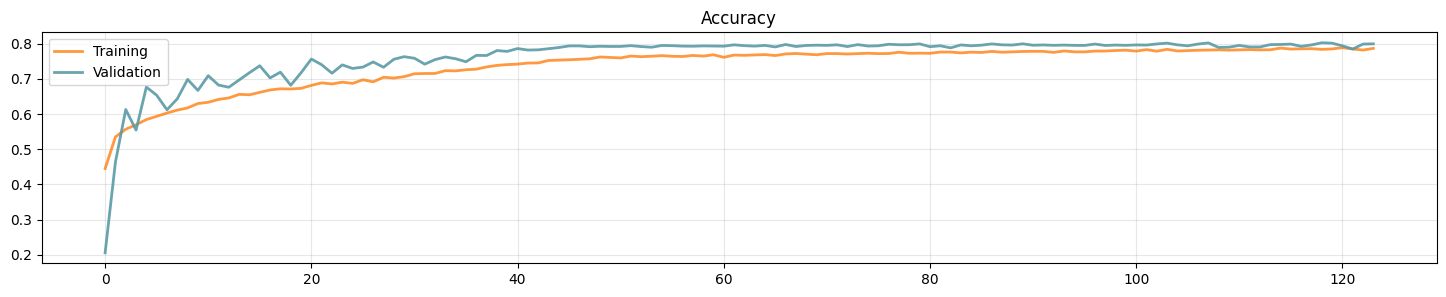

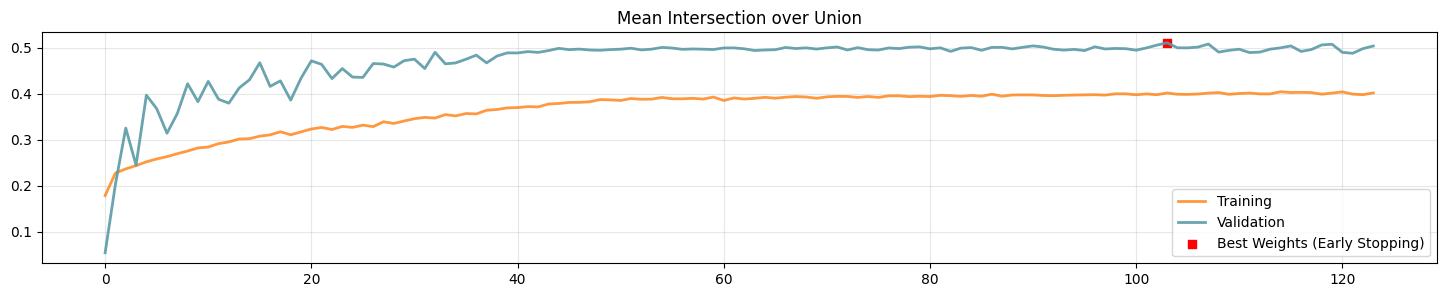

In [ ]:
best_epoch = history['val_mean_iou'].index(max(history['val_mean_iou']))



# Plot and display training and validation loss

plt.figure(figsize=(18, 3))

plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)

plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)

# plt.scatter(best_epoch, history['val_mean_iou'][best_epoch], color='red', marker='s', label='Best Weights (Early Stopping)')

plt.title('Cross Entropy Loss')

plt.legend()

plt.grid(alpha=0.3)

plt.show()



# Plot and display training and validation accuracy

plt.figure(figsize=(18, 3))

plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)

plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)

# plt.scatter(best_epoch, history['val_mean_iou'][best_epoch], color='red', marker='s', label='Best Weights (Early Stopping)')

plt.title('Accuracy')

plt.legend()

plt.grid(alpha=0.3)

plt.show()



# Plot and display training and validation mean IoU

plt.figure(figsize=(18, 3))

plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)

plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)

plt.scatter(best_epoch, history['val_mean_iou'][best_epoch], color='red', marker='s', label='Best Weights (Early Stopping)')

plt.title('Mean Intersection over Union')

plt.legend()

plt.grid(alpha=0.3)

plt.show()

In [ ]:
# save the model and remove it from memory

timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Model saved to model_241214_064450.keras


# 📊 Submission



In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.






In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive

if "model_filename" not in globals() or model_filename is None:

    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]

    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)

    if files:

        model_filename = files[0]

    else:

        raise FileNotFoundError("No model files found in the current directory.")

In [ ]:
model = tfk.models.load_model(model_filename)

print(f"Model loaded from {model_filename}")

Model loaded from model_241214_064450.keras


In [ ]:
preds = model.predict(X_test)

preds = np.argmax(preds, axis=-1)

print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 36s 110ms/step
Predictions shape: (10022, 64, 128)


In [ ]:
def y_to_df(y) -> pd.DataFrame:

    """Converts segmentation predictions into a DataFrame format for Kaggle."""

    n_samples = len(y)

    y_flat = y.reshape(n_samples, -1)

    df = pd.DataFrame(y_flat)

    df["id"] = np.arange(n_samples)

    cols = ["id"] + [col for col in df.columns if col != "id"]

    return df[cols]

In [ ]:
# Create and download the csv submission file

timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

# OPTUNA

## Model definition

In [ ]:
# create the model

def create_model(trial):
    model = dual_unet()
    #model = get_deeper_unet_model()

    learning_rate = trial.suggest_loguniform('learning_rate', 5e-7, 1e-4)
    opt = trial.suggest_categorical('optimizer', ['adamW', 'adam', 'Lion'])
    loss = trial.suggest_categorical('loss', [weighted_combined_loss(class_weights, alpha=0.5),
                                              focal_tversky_loss(class_weights=class_weights),
                                              masked_focal_tversky_loss(ignore_class=4, class_weights=class_weights)
                                              ])


    if opt == 'adamW':
        model.compile(optimizer=AdamW(learning_rate=learning_rate),
                      loss=loss,
                      metrics=[tfk.metrics.MeanIoU(num_classes=NUM_CLASSES, ignore_class=0, sparse_y_pred=False, name="mean_iou")]
                      )

    elif opt == 'adam':
        model.compile(optimizer=Adam(learning_rate=learning_rate),
                      loss=loss,
                      metrics=[tfk.metrics.MeanIoU(num_classes=NUM_CLASSES, ignore_class=0, sparse_y_pred=False, name="mean_iou")]
                      )

    else:
        model.compile(optimizer=Lion(learning_rate=learning_rate),
                      loss=loss,
                      metrics=[tfk.metrics.MeanIoU(num_classes=NUM_CLASSES, ignore_class=0, sparse_y_pred=False, name="mean_iou")]
                      )
    return model

## Hyperparameter optimization (Optuna)

In [ ]:
def objective(trial):
    # Clear clutter from previous session graphs.
    tfk.backend.clear_session()

    model = create_model(trial)


    batch_size = 32
    num_augmentations = 3

    history = model.fit(
        data_generator(X_train, y_train, batch_size=batch_size, num_augmentations=num_augmentations),
        steps_per_epoch=(len(X_train) * num_augmentations) // batch_size,
        epochs=150,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, lr_scheduling],
        verbose=1
    ).history

    val_MIOU = max(history['val_mean_iou'])
    return val_MIOU

In [ ]:
start_time = time.time()

# Esecuzione di Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=150)

# to know how long was the Hyperparameter optimization
elapsed_time = time.time() - start_time
print('Hyperparameter optimization finished...')
print(f'elapsed time: {elapsed_time / 60} minutes\n')

# Final results
best_params = study.best_params
print("Best validation MIOU: ", study.best_value)
print("Best hyperparameters: ", study.best_params)

## Final Training

In [ ]:
# Training finale con i migliori parametri
opt_tl_model = create_model(
    loss=best_params['loss']
    learning_rate=best_params['learning_rate'],
    optimizer=best_params['optimizer']
)

opt_tl_model.summary(expand_nested=True)
tfk.utils.plot_model(opt_tl_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
# Train the model
batch_size = 16
num_augmentations = 3

start_time = time.time()

history = opt_tl_model.fit(
    data_generator(X_train, y_train, batch_size=batch_size, num_augmentations=num_augmentations),
    steps_per_epoch=(len(X_train) * num_augmentations) // batch_size,
    epochs=150,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduling, viz_callback],
    verbose=1,
).history

# to know how long was the training
elapsed_time = time.time() - start_time
print('Training finished...')
print(f'elapsed time: {elapsed_time / 60} minutes\n')

# Calculate and print the final validation Mean Intersection Over Union
final_val_mean_iou = max(history['val_mean_iou'])* 100
print(f'Final validation Mean Intersection Over Union: {final_val_mean_iou} %')

Epoch 1/150


In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Combined Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()